In [365]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [366]:
df = pd.read_csv('us_state_vaccinations.csv')
df.head()

date location  total_vaccinations  total_distributed  \
0  2021-01-12  Alabama             78134.0           377025.0   
1  2021-01-13  Alabama             84040.0           378975.0   
2  2021-01-14  Alabama             92300.0           435350.0   
3  2021-01-15  Alabama            100567.0           444650.0   
4  2021-01-16  Alabama                 NaN                NaN   

   people_vaccinated  people_fully_vaccinated_per_hundred  \
0            70861.0                                 0.15   
1            74792.0                                 0.19   
2            80480.0                                  NaN   
3            86956.0                                 0.28   
4                NaN                                  NaN   

   total_vaccinations_per_hundred  people_fully_vaccinated  \
0                            1.59                   7270.0   
1                            1.71                   9245.0   
2                            1.88                      NaN   
3                            2.05                  13488.0   
4                             NaN                      NaN   

   people_vaccinated_per_hundred  distributed_per_hundred  \
0                           1.45                     7.69   
1                           1.53                     7.73   
2                           1.64                     8.88   
3                           1.77                     9.07   
4                            NaN                      NaN   

   daily_vaccinations_raw  daily_vaccinations  daily_vaccinations_per_million  \
0                     NaN                 NaN                             NaN   
1                  5906.0              5906.0                          1205.0   
2                  8260.0              7083.0                          1445.0   
3                  8267.0              7478.0                          1525.0   
4                     NaN              7498.0                          1529.0   

   share_doses_used  total_boosters  total_boosters_per_hundred  
0             0.207             NaN                         NaN  
1             0.222             NaN                         NaN  
2             0.212             NaN                         NaN  
3             0.226             NaN                         NaN  
4               NaN             NaN                         NaN

In [367]:
df['date'].isna().value_counts()  #This means that our date column is consistent as we have no NaN values in it

date
False    54628
Name: count, dtype: int64

In [368]:
df1 = df.drop(columns = ['total_vaccinations', 'total_distributed', 'people_vaccinated', 'people_fully_vaccinated_per_hundred', 'total_vaccinations_per_hundred', 'people_fully_vaccinated', 'people_vaccinated_per_hundred', 'distributed_per_hundred', 'daily_vaccinations_raw', 'daily_vaccinations_per_million', 'share_doses_used', 'total_boosters', 'total_boosters_per_hundred'])

In [369]:
df1.head()

date location  daily_vaccinations
0  2021-01-12  Alabama                 NaN
1  2021-01-13  Alabama              5906.0
2  2021-01-14  Alabama              7083.0
3  2021-01-15  Alabama              7478.0
4  2021-01-16  Alabama              7498.0

In [370]:
df1 = df1[df1['location'] != 'United States']

In [371]:
print(df1[['date', 'location', 'daily_vaccinations']].isna().sum())

date                   0
location               0
daily_vaccinations    64
dtype: int64


In [372]:
df2 = df1.copy()
df2['daily_vaccinations'] = df2.groupby('location')['daily_vaccinations'].transform(
    lambda x: x.interpolate(method='linear').ffill().bfill()
)

In [373]:
print(df2[['date', 'location', 'daily_vaccinations']].isna().sum())

date                  0
location              0
daily_vaccinations    0
dtype: int64


In [374]:
df2.head()

date location  daily_vaccinations
0  2021-01-12  Alabama              5906.0
1  2021-01-13  Alabama              5906.0
2  2021-01-14  Alabama              7083.0
3  2021-01-15  Alabama              7478.0
4  2021-01-16  Alabama              7498.0

In [375]:
# convert date to datetime
df2['date'] = pd.to_datetime(df2['date'])

df2 = df2.sort_values(['location', 'date'])

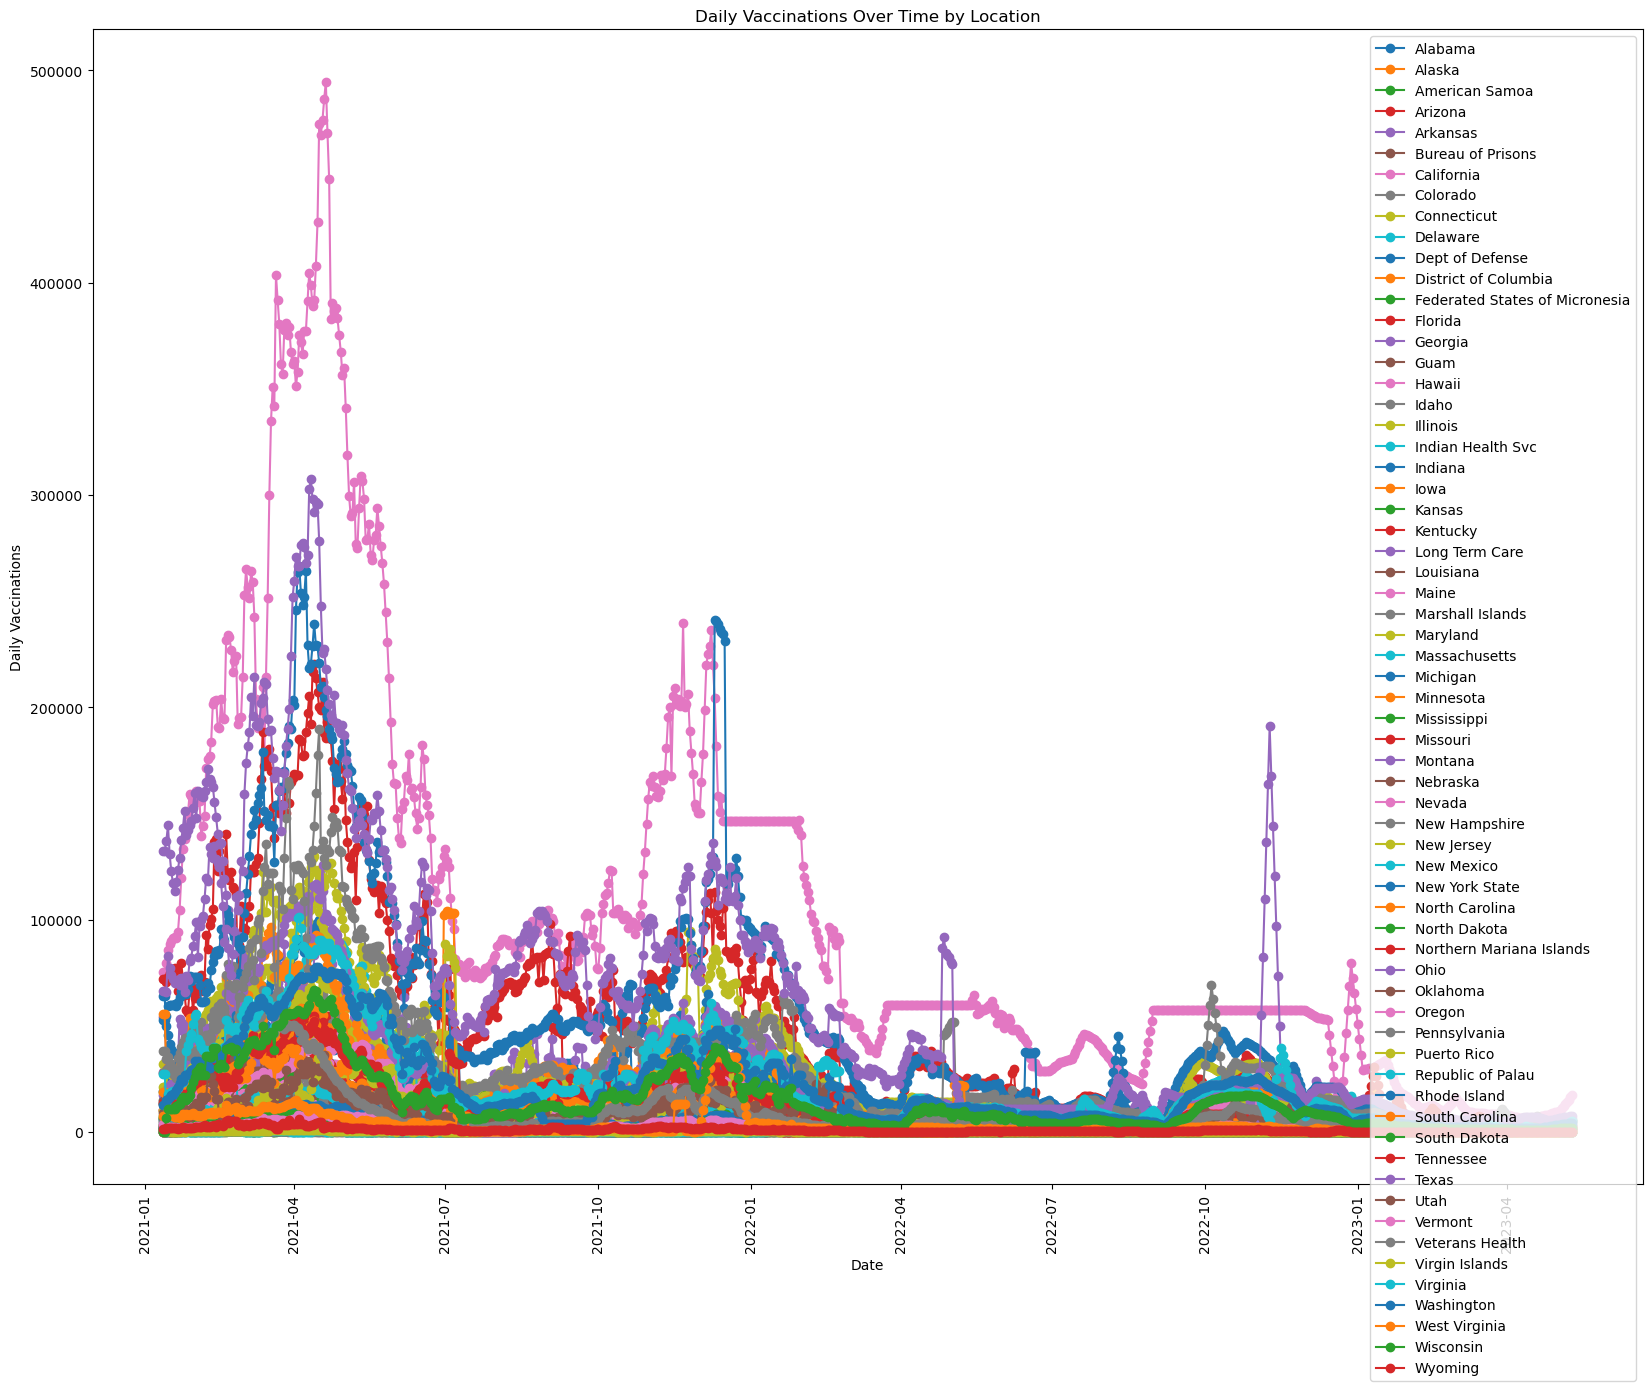

In [376]:
plt.figure(figsize=(20, 15))
for location in df2['location'].unique():
    location_data = df2[df2['location'] == location]
    plt.plot(location_data['date'], location_data['daily_vaccinations'], marker='o', label=location)

plt.xticks(rotation='vertical')
plt.title("Daily Vaccinations Over Time by Location")
plt.xlabel("Date")
plt.ylabel("Daily Vaccinations")
plt.legend()
plt.show()

In [377]:
df2

date location  daily_vaccinations
0     2021-01-12  Alabama              5906.0
1     2021-01-13  Alabama              5906.0
2     2021-01-14  Alabama              7083.0
3     2021-01-15  Alabama              7478.0
4     2021-01-16  Alabama              7498.0
...          ...      ...                 ...
54623 2023-05-06  Wyoming                77.0
54624 2023-05-07  Wyoming               100.0
54625 2023-05-08  Wyoming               123.0
54626 2023-05-09  Wyoming               146.0
54627 2023-05-10  Wyoming               170.0

[53756 rows x 3 columns]

In [378]:
#!pip install prophet
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [379]:
models = {}
forecasts = {}
performance = {}
naive_performance = {}  # For baseline comparison

# Shorter forecast period for better accuracy
future_period = 14  # Reduced from 30

for location in df2['location'].unique():
    location_data = df2[df2['location'] == location]
    
    if len(location_data) < 7:  # Need at least a week of data
        print(f"Not enough data for {location}. Skipping.")
        continue
    
    # Prepare data with log transformation to stabilize variance
    prophet_df = location_data[['date', 'daily_vaccinations']].rename(
        columns={'date': 'ds', 'daily_vaccinations': 'y'})
    
    # Apply log transformation to handle non-stationarity
    prophet_df['y'] = np.log1p(prophet_df['y'])  # log(1+y) to avoid log(0)
    
    # Validation split
    test_size = max(future_period, int(len(prophet_df) * 0.2))
    if test_size >= len(prophet_df):
        print(f"Insufficient data for {location}. Skipping validation.")
        test_size = 0
        
    if test_size > 0:
        train = prophet_df.iloc[:-test_size]
        test = prophet_df.iloc[-test_size:]
        
        # Calculate naive forecast for baseline comparison
        naive_preds = test['y'].shift(1).fillna(method='bfill').values
        naive_performance[location] = {
            'MAE': mean_absolute_error(test['y'].values, naive_preds),
            'RMSE': np.sqrt(mean_squared_error(test['y'].values, naive_preds))
        }
    else:
        train, test = prophet_df, pd.DataFrame({'ds': [], 'y': []})

    try:
        # Validation with optimized Prophet parameters
        if len(test) > 0:
            val_model = Prophet(
                changepoint_prior_scale=0.01,  # More flexible trend changes
                seasonality_prior_scale=10.0,  # Stronger weekly patterns
                seasonality_mode='multiplicative',  # Better for vaccination patterns
                weekly_seasonality=True
            )
            
            val_model.fit(train)
            future = val_model.make_future_dataframe(periods=len(test))
            forecast = val_model.predict(future)
            
            # Transform predictions back to original scale
            val_predictions = np.expm1(forecast.iloc[-len(test):]['yhat'].values)
            test_actual = np.expm1(test['y'].values)
            
            # Store comprehensive metrics
            performance[location] = {
                'MAE': mean_absolute_error(test_actual, val_predictions),
                'RMSE': np.sqrt(mean_squared_error(test_actual, val_predictions)),
                'MAPE': np.mean(np.abs((test_actual - val_predictions) / (test_actual + 1))) * 100
            }

        # Full model with same optimized parameters
        model = Prophet(
            changepoint_prior_scale=0.01,
            seasonality_prior_scale=10.0,
            seasonality_mode='multiplicative',
            weekly_seasonality=True
        )
        
        model.fit(prophet_df)
        future = model.make_future_dataframe(periods=future_period)
        forecast = model.predict(future)
        
        # Reverse log transformation
        for col in ['yhat', 'yhat_lower', 'yhat_upper']:
            forecast[col] = np.expm1(forecast[col])
        
        models[location] = model
        forecasts[location] = forecast
        
        print(f"Successfully processed {location}")
        
    except Exception as e:
        print(f"Error with {location}: {e}")
        
# Combine forecasts
combined_forecasts = pd.DataFrame()
for location, forecast in forecasts.items():
    temp = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
    temp['location'] = location
    combined_forecasts = pd.concat([combined_forecasts, temp])

# Generate summary statistics
forecast_summary = pd.DataFrame({
    'location': [],
    'current_value': [],
    'predicted_end_value': [],
    'growth_rate': []
})

for location, model in models.items():
    location_data = df2[df2['location'] == location]
    current = location_data['daily_vaccinations'].iloc[-1]
    final = forecasts[location]['yhat'].iloc[-1]
    
    growth = ((final - current) / current) * 100 if current != 0 else 0
    
    forecast_summary = pd.concat([forecast_summary, pd.DataFrame({
        'location': [location],
        'current_value': [current],
        'predicted_end_value': [final],
        'growth_rate': [growth]
    })])

# Calculate 7-day rolling average for specific locations
location_data = df2[df2['location'] == 'Alabama']
location_data['daily_avg'] = location_data['daily_vaccinations'].rolling(7).mean()
latest_avg = location_data['daily_avg'].iloc[-1]

C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:25 - cmdstanpy - INFO - Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing
15:05:25 - cmdstanpy - INFO - Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:25 - cmdstanpy - INFO - Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Alabama


15:05:26 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:26 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Alaska


15:05:26 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:26 - cmdstanpy - INFO - Chain [1] start processing
15:05:26 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed American Samoa


15:05:26 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Arizona


15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Arkansas


15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:27 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:27 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Bureau of Prisons


15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed California


15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:28 - cmdstanpy - INFO - Chain [1] start processing
15:05:28 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Colorado


15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Connecticut


15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Delaware


15:05:29 - cmdstanpy - INFO - Chain [1] start processing
15:05:29 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Dept of Defense


15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed District of Columbia


15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:30 - cmdstanpy - INFO - Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Federated States of Micronesia


15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Florida


15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:31 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Georgia


15:05:31 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Guam


15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Hawaii


15:05:32 - cmdstanpy - INFO - Chain [1] start processing
15:05:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Idaho


15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Illinois


15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:33 - cmdstanpy - INFO - Chain [1] start processing
15:05:33 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Indian Health Svc


15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Indiana


15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:34 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Iowa


15:05:34 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Kansas


15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing
15:05:35 - cmdstanpy - INFO - Chain [1] start processing


Successfully processed Kentucky


15:05:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:35 - cmdstanpy - INFO - Chain [1] start processing
15:05:35 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Long Term Care


15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Louisiana


15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:36 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Maine


15:05:36 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Marshall Islands


15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Maryland


15:05:37 - cmdstanpy - INFO - Chain [1] start processing
15:05:37 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:38 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Massachusetts


15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:38 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Michigan


15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:38 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Minnesota


15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Mississippi


15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:39 - cmdstanpy - INFO - Chain [1] start processing
15:05:39 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Missouri


15:05:40 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:40 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Montana


15:05:40 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:40 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Nebraska


15:05:40 - cmdstanpy - INFO - Chain [1] start processing
15:05:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:41 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Nevada


15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:41 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed New Hampshire


15:05:41 - cmdstanpy - INFO - Chain [1] start processing
15:05:41 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:42 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed New Jersey


15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:42 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed New Mexico


15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:42 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:42 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed New York State


15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed North Carolina


15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:43 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed North Dakota


15:05:43 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Northern Mariana Islands


15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Ohio


15:05:44 - cmdstanpy - INFO - Chain [1] start processing
15:05:44 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Oklahoma


15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Oregon


15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:45 - cmdstanpy - INFO - Chain [1] start processing
15:05:45 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Pennsylvania


15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Puerto Rico


15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Republic of Palau


15:05:46 - cmdstanpy - INFO - Chain [1] start processing
15:05:46 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:47 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Rhode Island


15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:47 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed South Carolina


15:05:47 - cmdstanpy - INFO - Chain [1] start processing
15:05:47 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed South Dakota


15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Tennessee


15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:48 - cmdstanpy - INFO - Chain [1] start processing
15:05:48 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Texas


15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Utah


15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:49 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Vermont


15:05:49 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:50 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Veterans Health


15:05:50 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:50 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Virgin Islands


15:05:50 - cmdstanpy - INFO - Chain [1] start processing
15:05:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Virginia


15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Washington


15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:51 - cmdstanpy - INFO - Chain [1] start processing
15:05:51 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed West Virginia


15:05:52 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:34: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

15:05:52 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Wisconsin


15:05:52 - cmdstanpy - INFO - Chain [1] start processing
15:05:52 - cmdstanpy - INFO - Chain [1] done processing


Successfully processed Wyoming


C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\2791025474.py:122: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [380]:
if 'Alabama' in performance and 'Alabama' in naive_performance:
    print(f"Model MAE: {performance['Alabama']['MAE']:.2f}")
    print(f"Naive MAE: {naive_performance['Alabama']['MAE']:.2f}")
    print(f"MAE as % of actual: {performance['Alabama']['MAE']/latest_avg*100:.2f}%")
    
    # Calculate MASE (Mean Absolute Scaled Error)
    mase = performance['Alabama']['MAE'] / naive_performance['Alabama']['MAE']
    print(f"MASE: {mase:.2f} (>1 means worse than naive forecast)")

Model MAE: 1074.09
Naive MAE: 0.04
MAE as % of actual: 219.52%
MASE: 23881.27 (>1 means worse than naive forecast)


In [381]:
forecast_summary.head()

location  current_value  predicted_end_value  growth_rate
0         Alabama          522.0           321.024094   -38.501131
0          Alaska          226.0            86.710924   -61.632334
0  American Samoa            2.0             0.167217   -91.639169
0         Arizona         2358.0          1189.778049   -49.542916
0        Arkansas          470.0           216.152875   -54.010027

In [382]:
combined_forecasts.head()

ds          yhat    yhat_lower    yhat_upper location
0 2021-01-12  30657.191527  17240.043357  49809.862468  Alabama
1 2021-01-13  29919.990902  17204.835518  53057.524051  Alabama
2 2021-01-14  29650.775631  16730.846072  49443.878289  Alabama
3 2021-01-15  29347.589396  16859.193732  50855.360587  Alabama
4 2021-01-16  28831.775123  16593.663476  49753.455570  Alabama

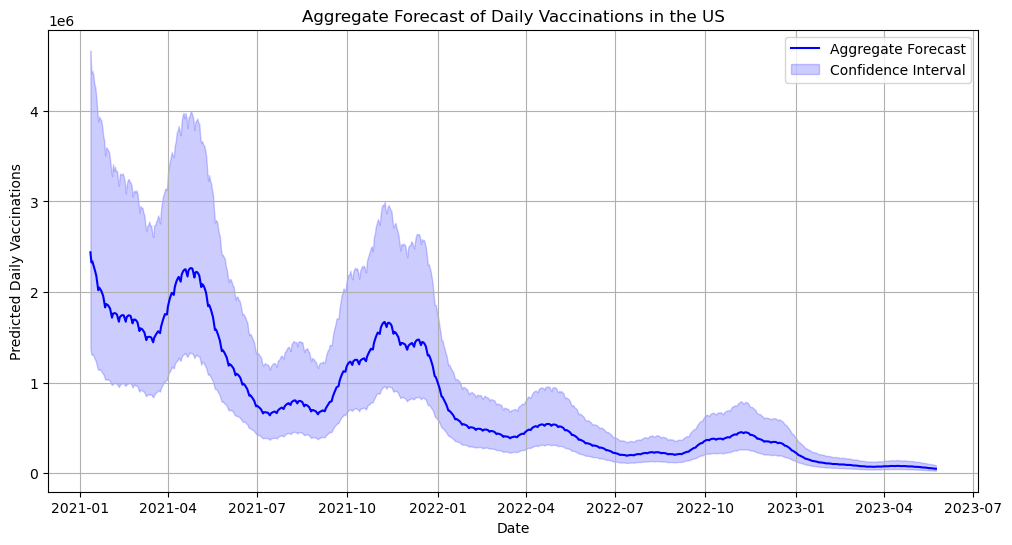

In [383]:
aggregate_forecast = combined_forecasts.groupby('ds')['yhat'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(aggregate_forecast['ds'], aggregate_forecast['yhat'], label='Aggregate Forecast', color='blue')
plt.fill_between(aggregate_forecast['ds'], 
                 combined_forecasts.groupby('ds')['yhat_lower'].sum(),
                 combined_forecasts.groupby('ds')['yhat_upper'].sum(), 
                 color='blue', alpha=0.2, label='Confidence Interval')
plt.title("Aggregate Forecast of Daily Vaccinations in the US")
plt.xlabel("Date")
plt.ylabel("Predicted Daily Vaccinations")
plt.legend()
plt.grid()
plt.show()

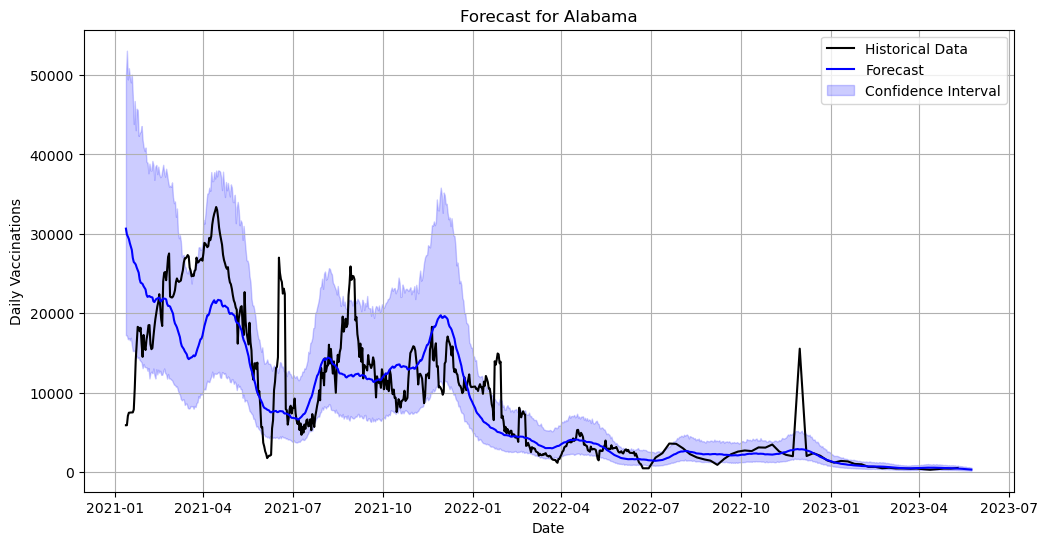

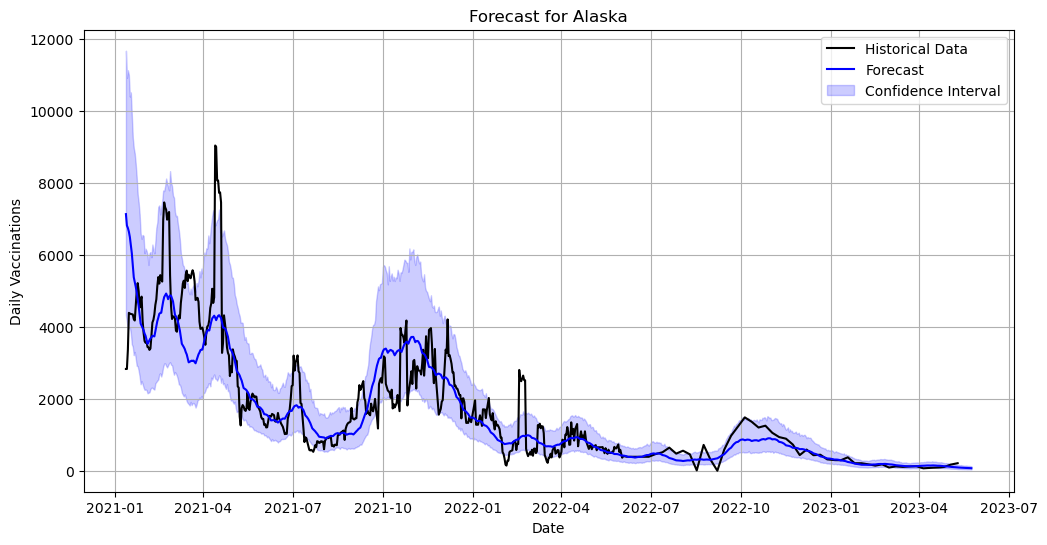

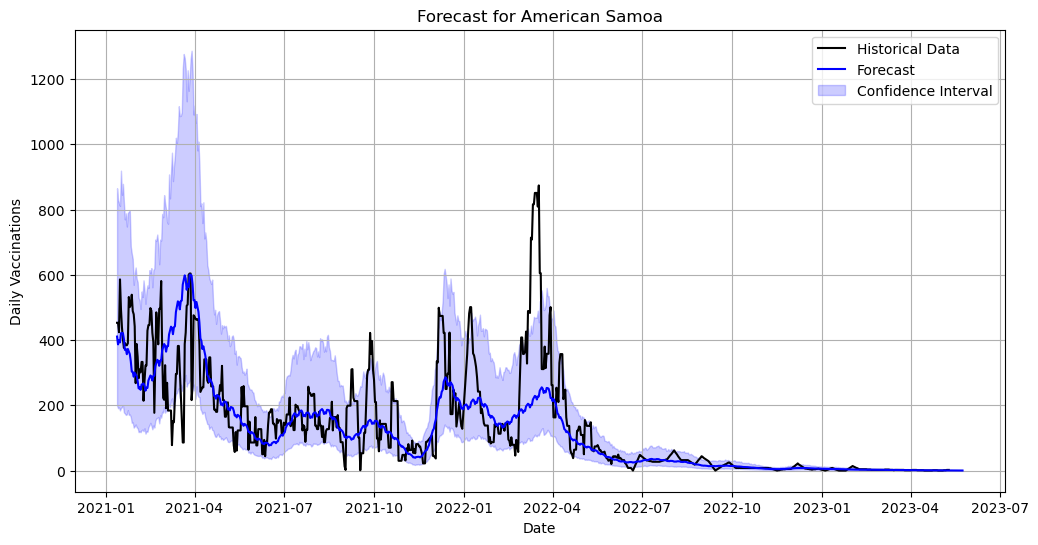

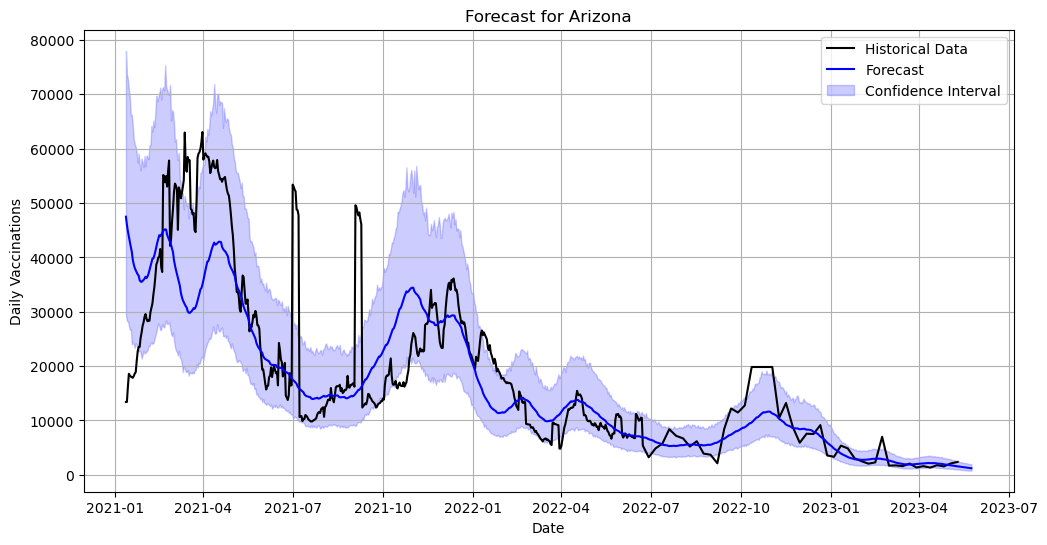

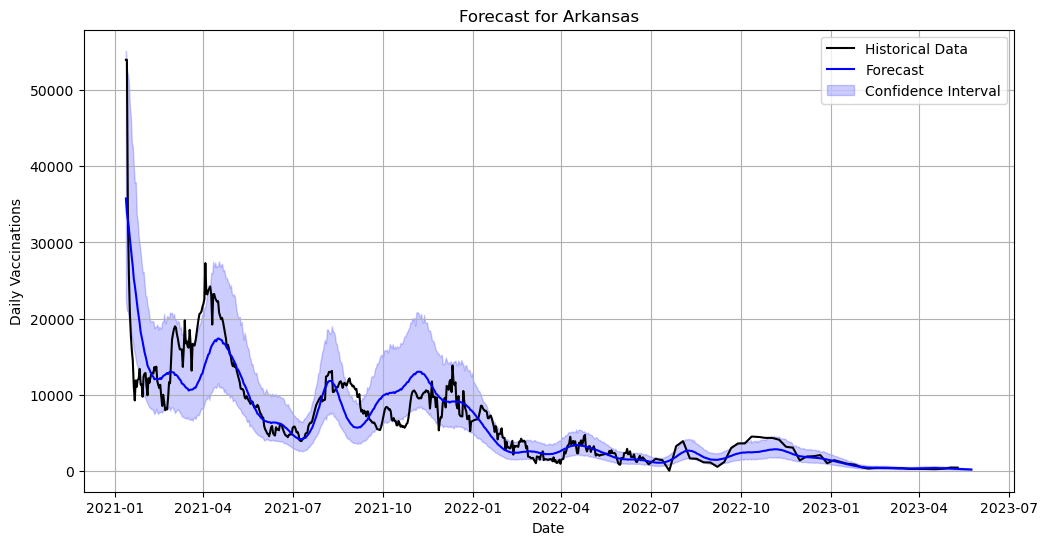

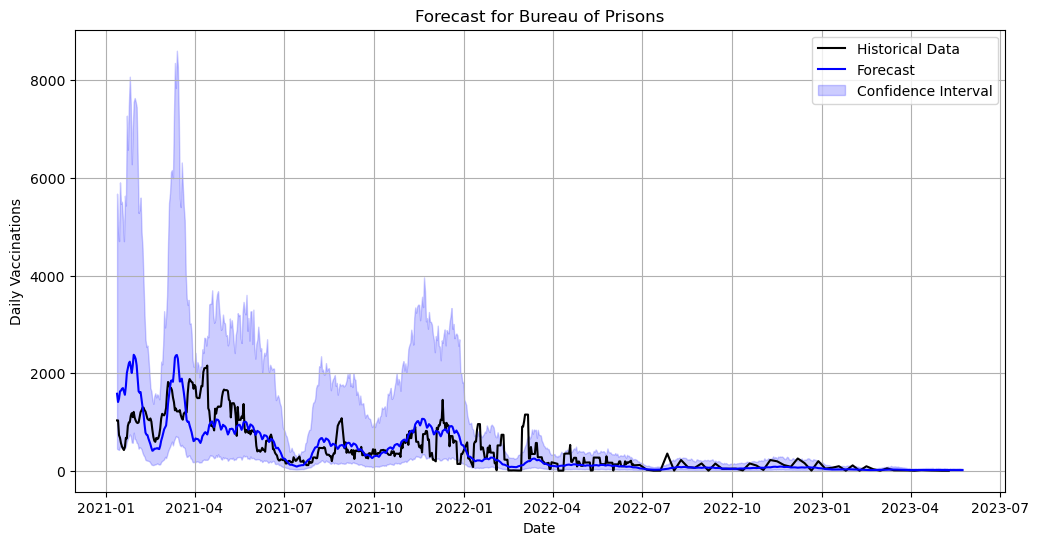

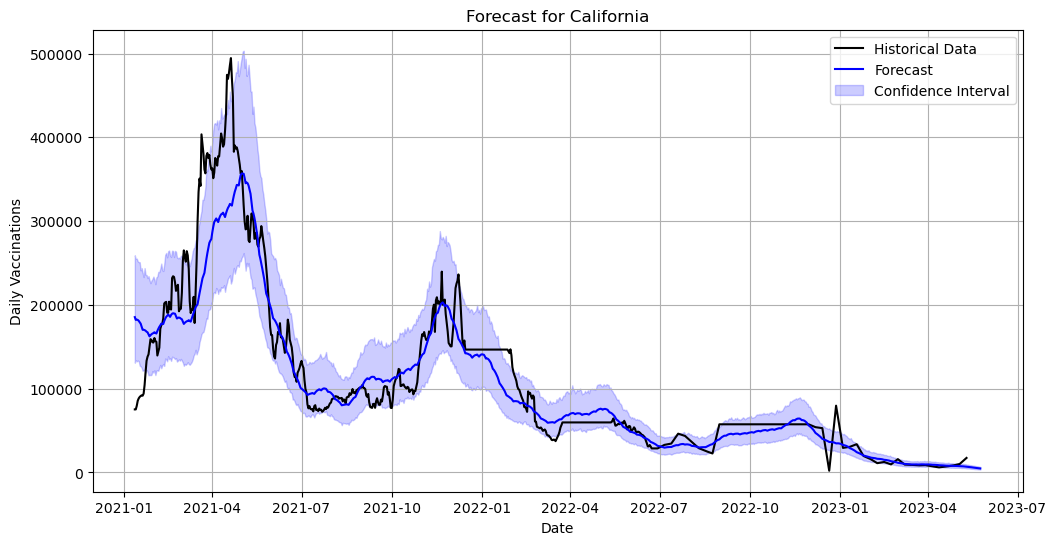

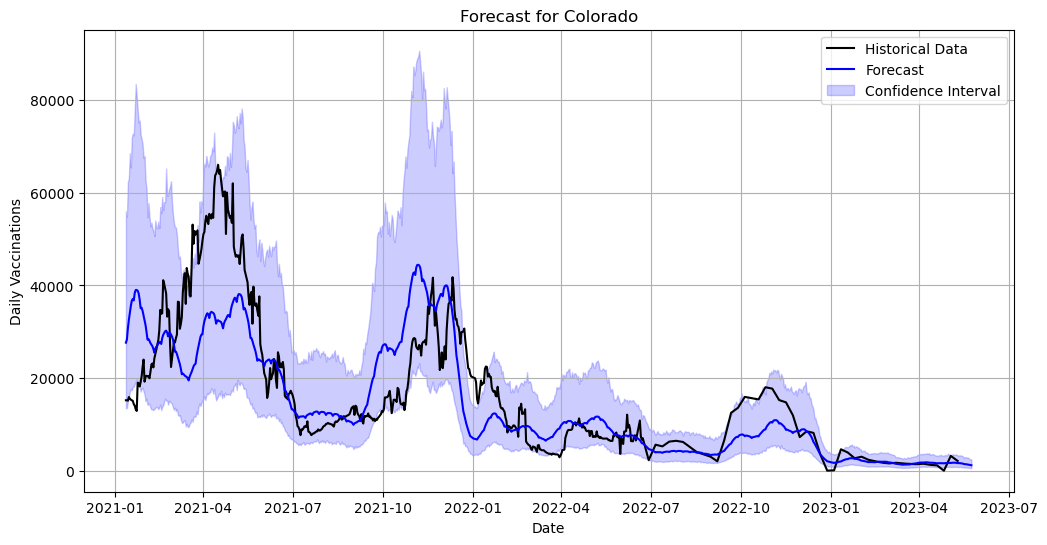

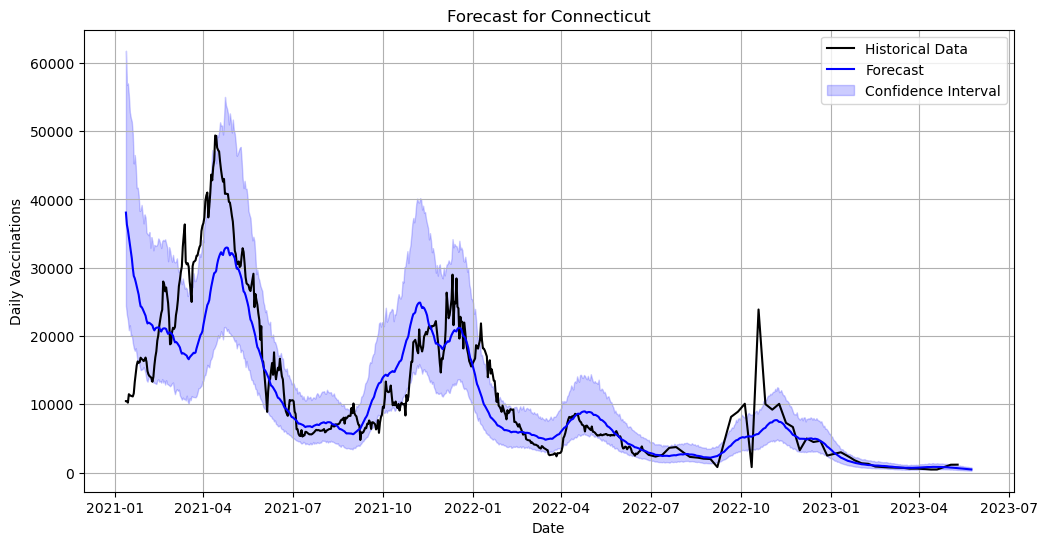

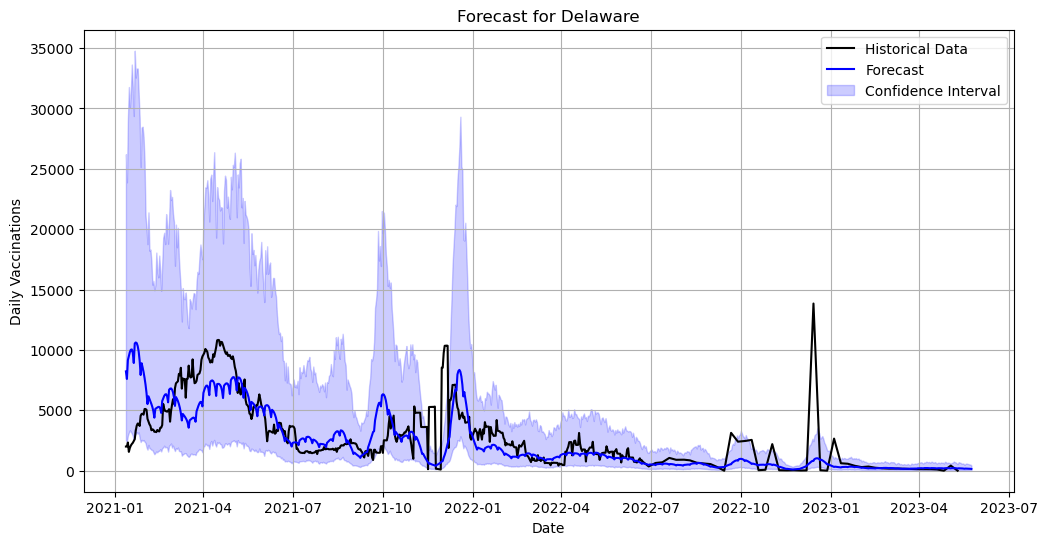

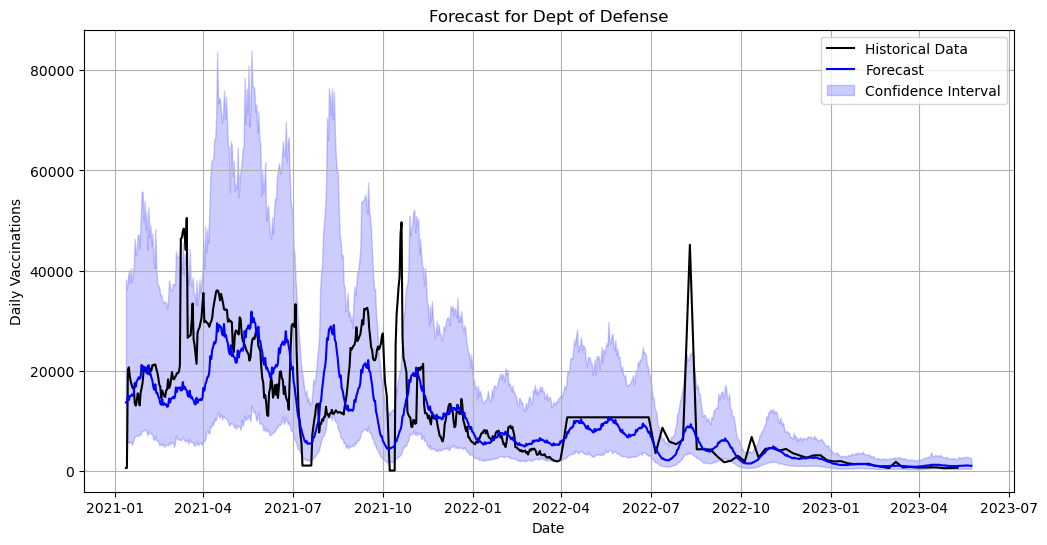

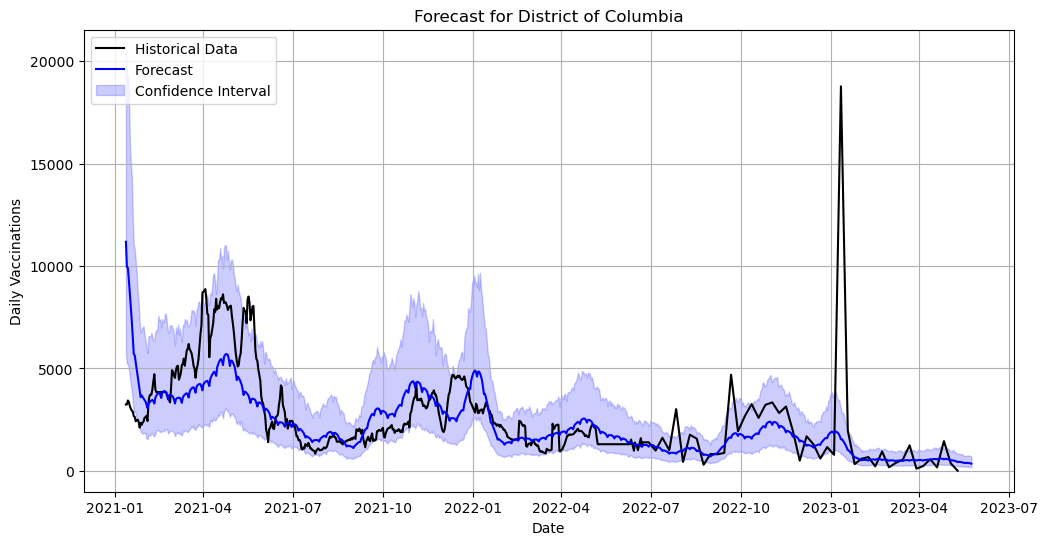

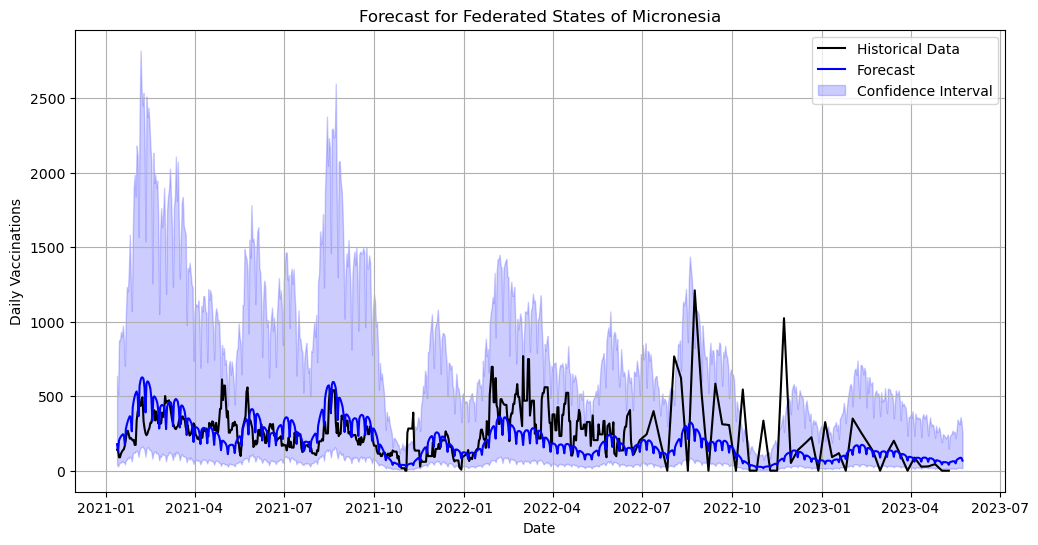

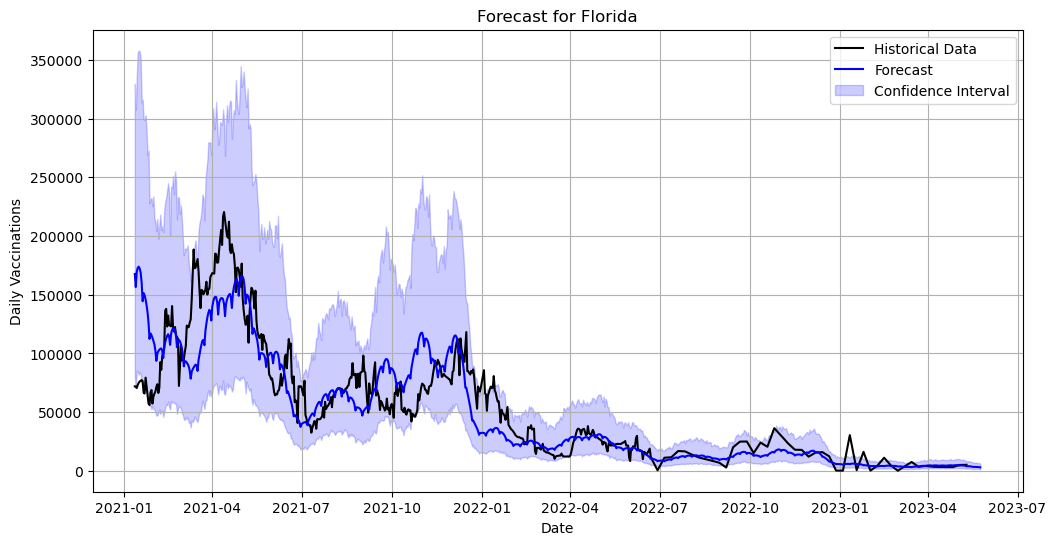

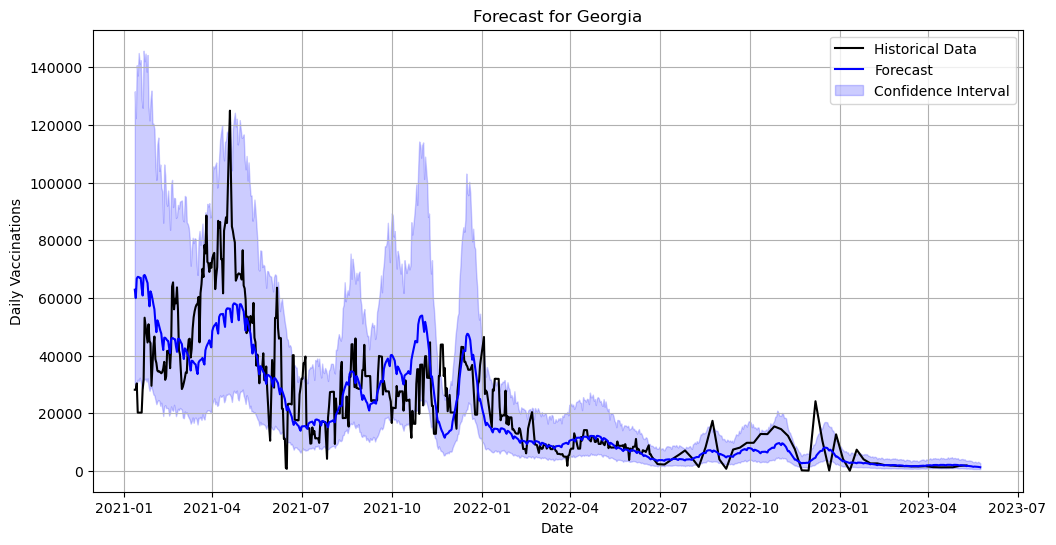

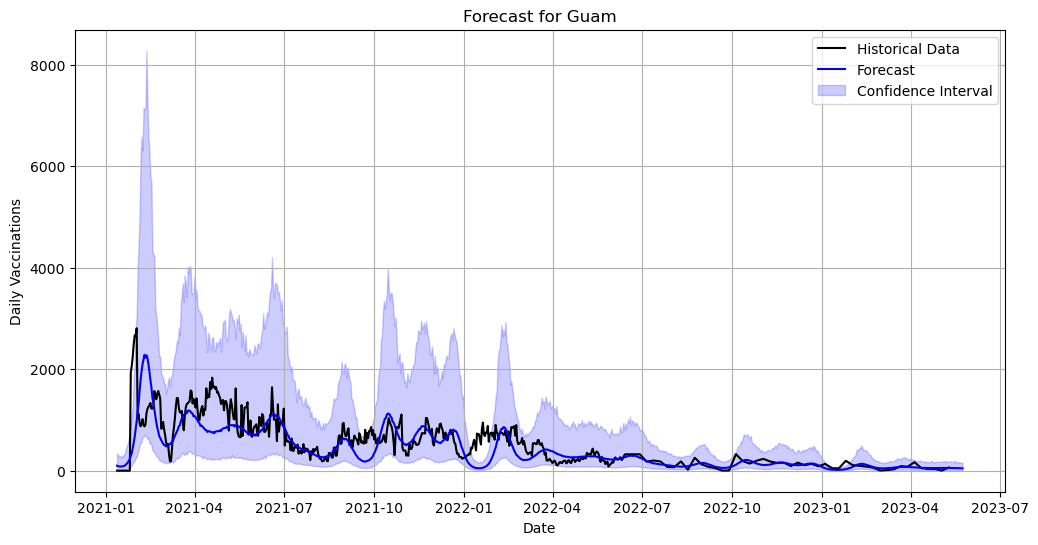

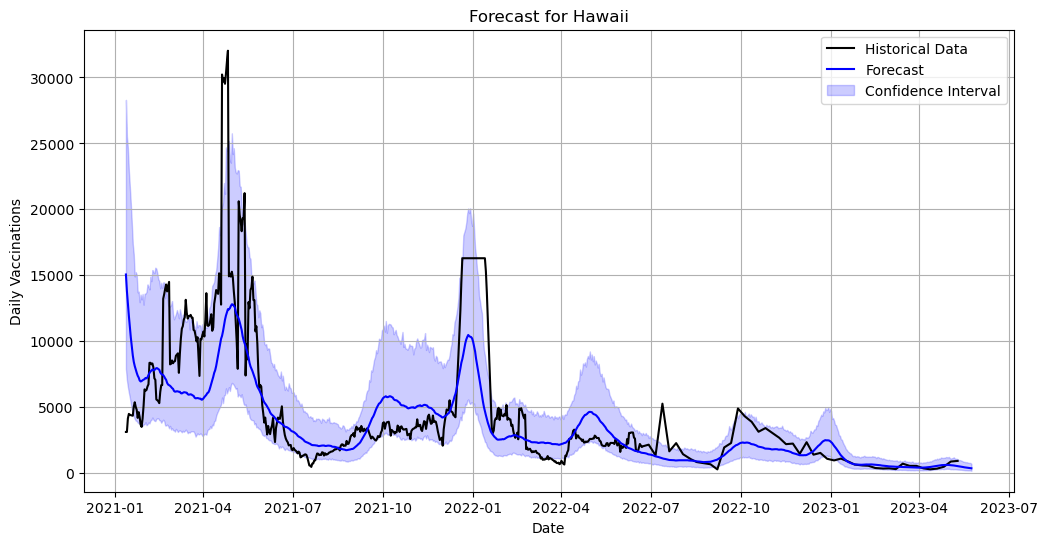

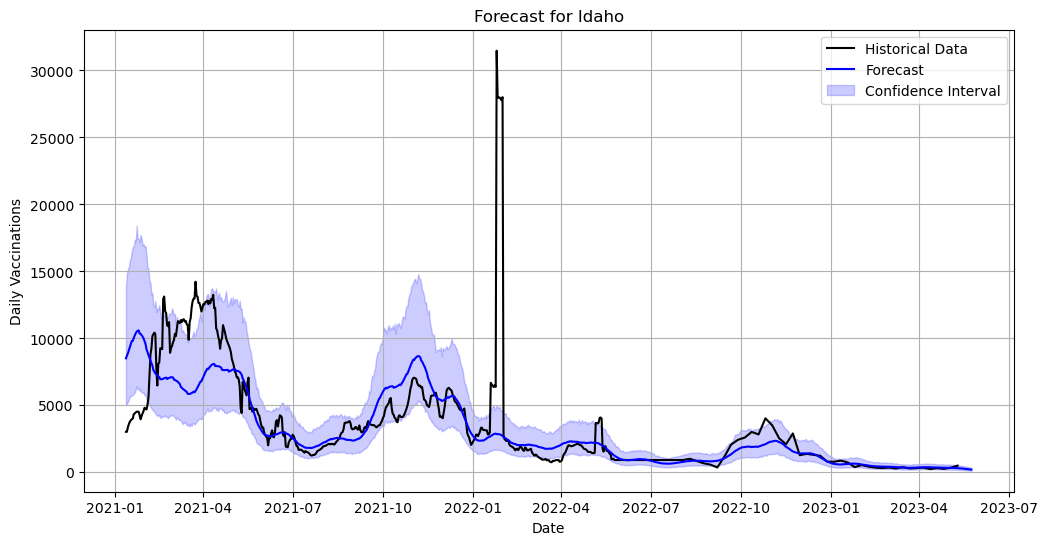

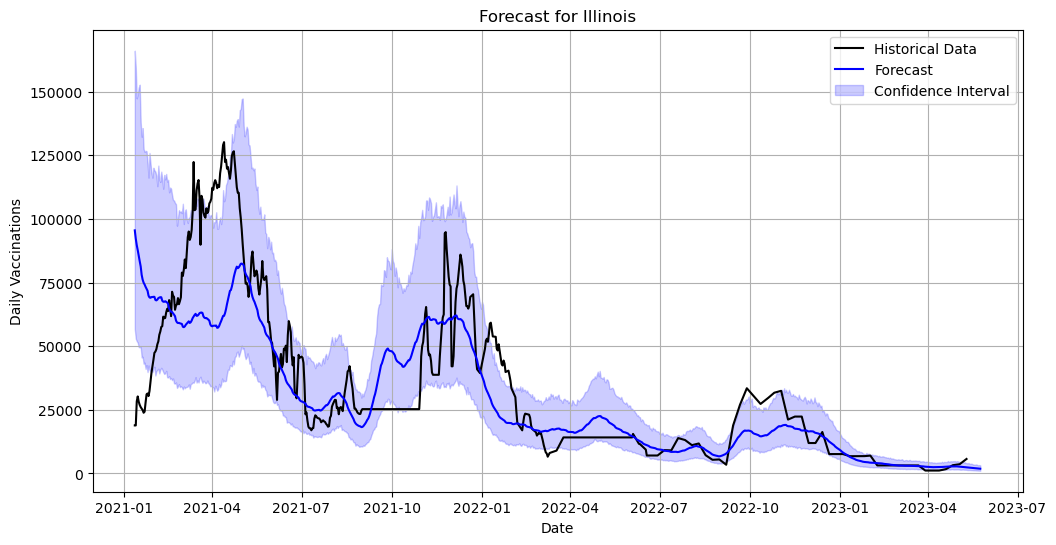

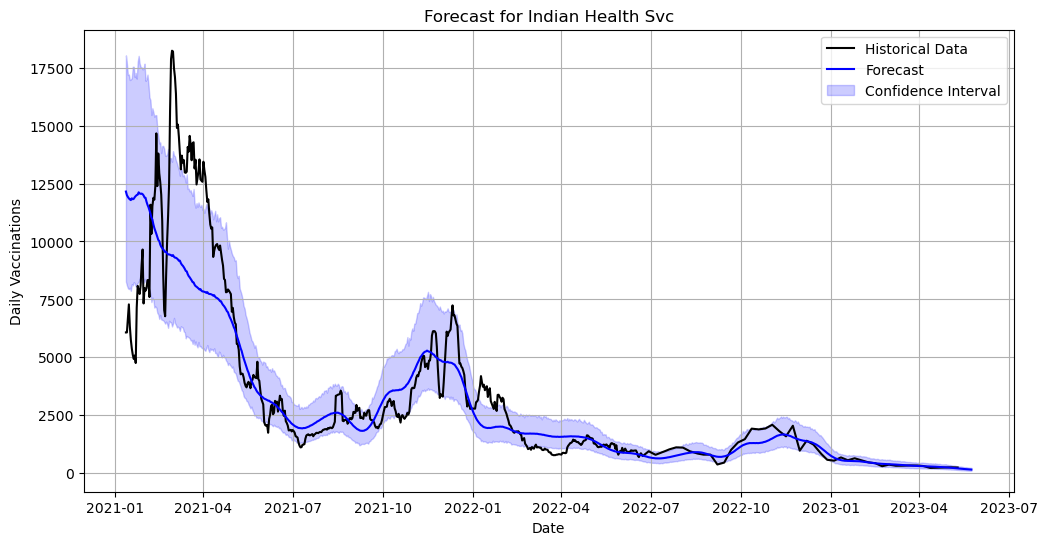

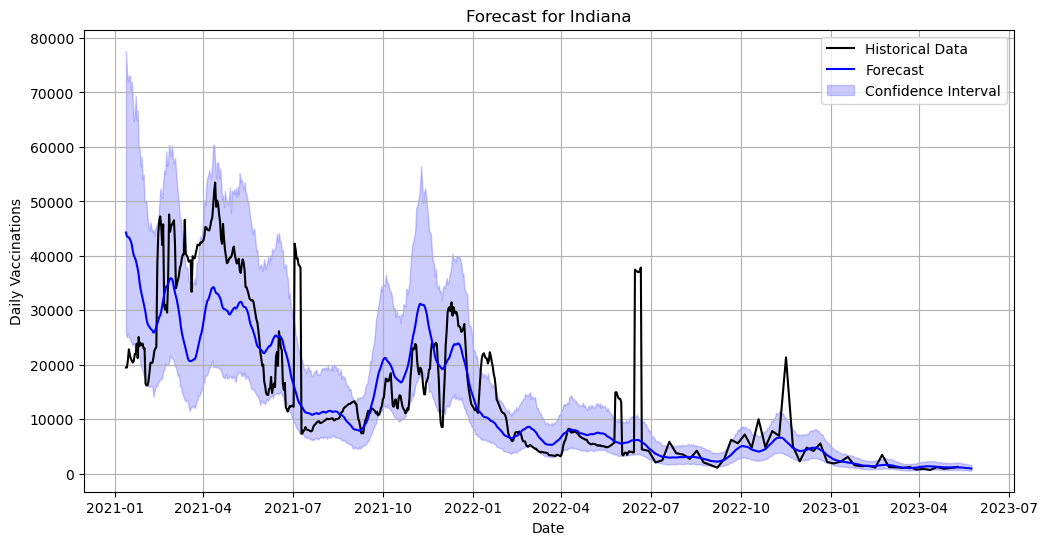

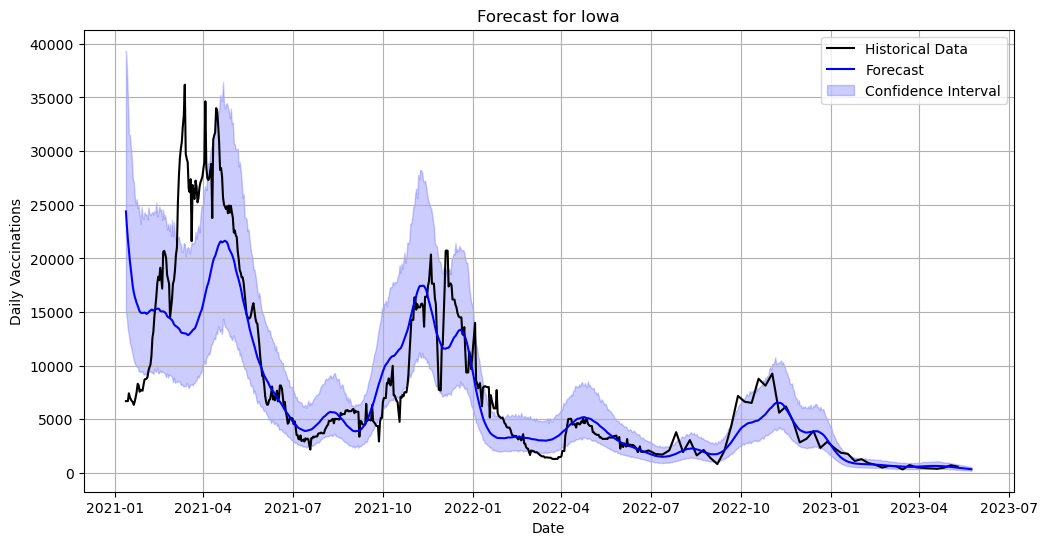

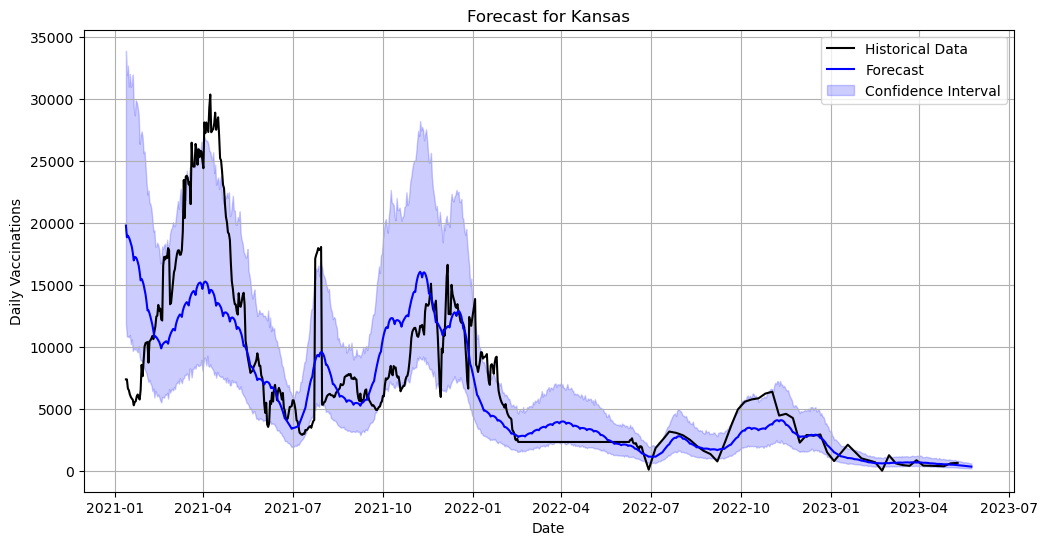

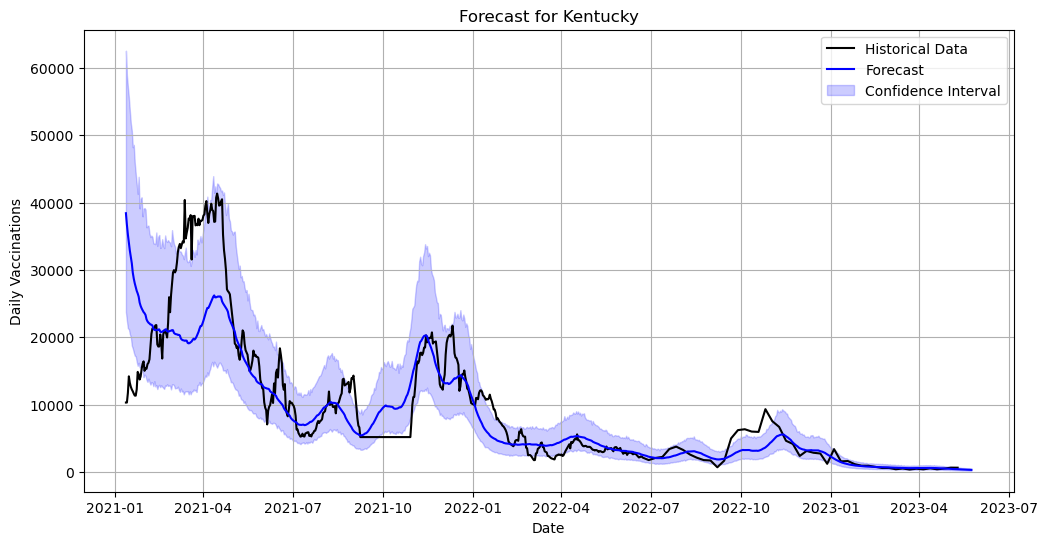

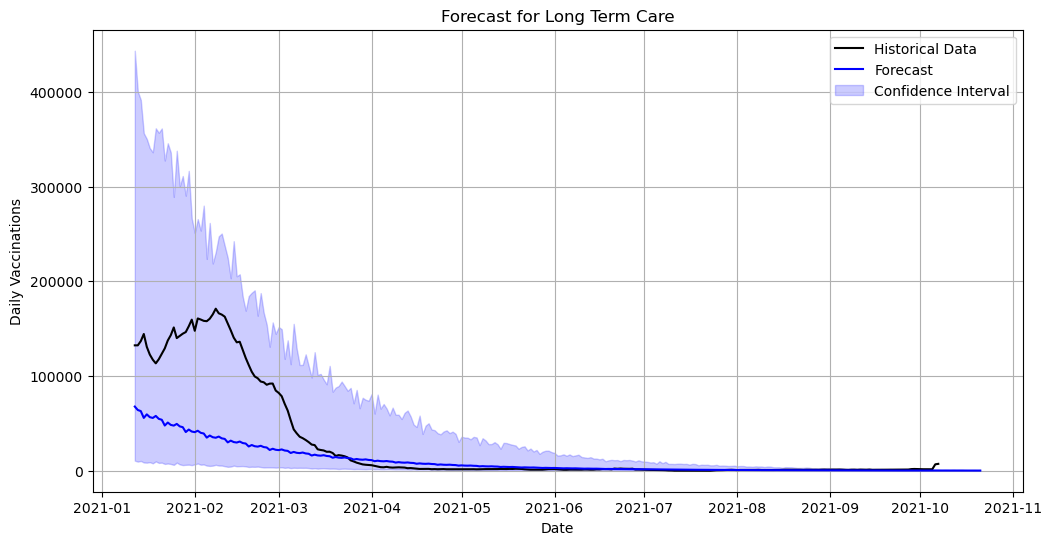

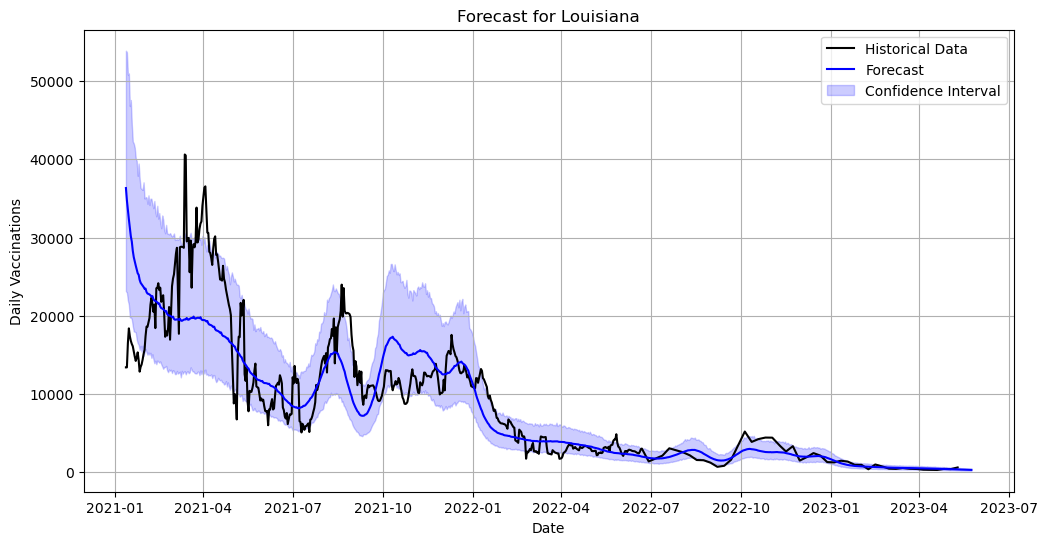

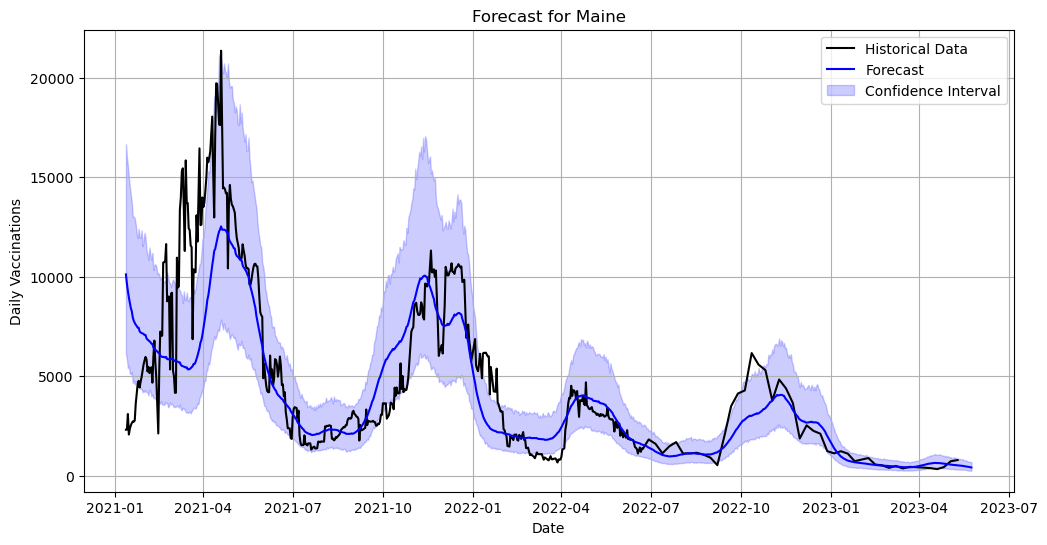

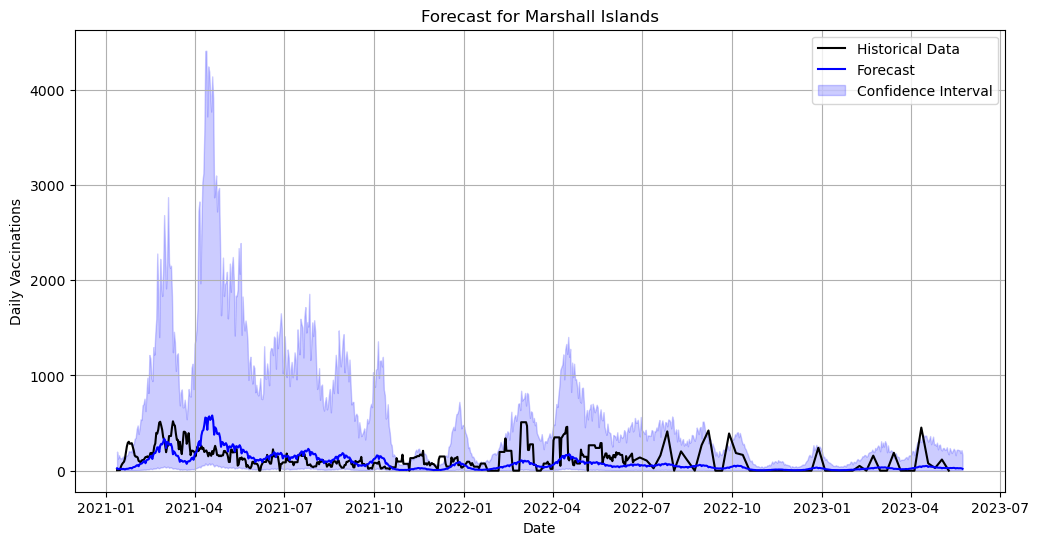

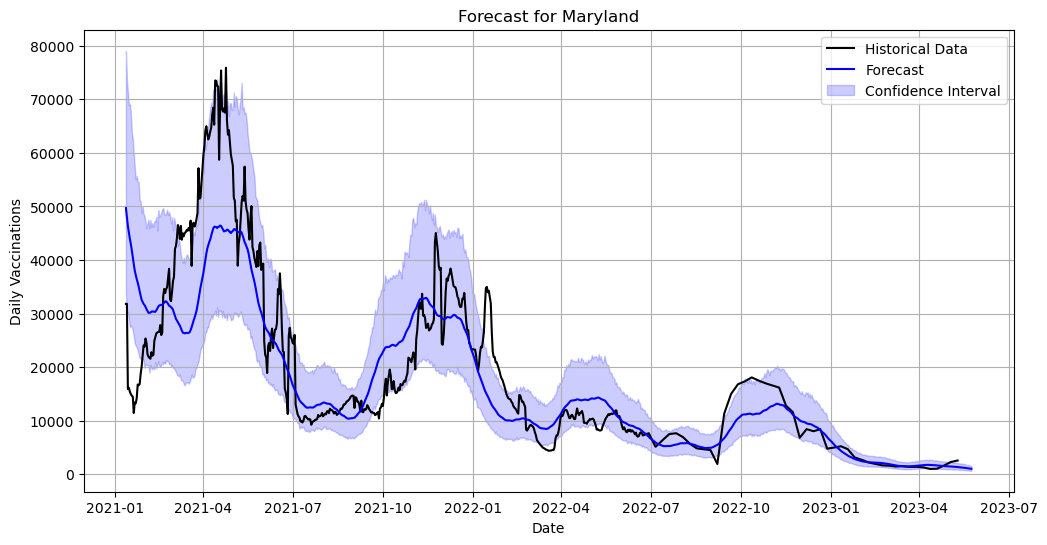

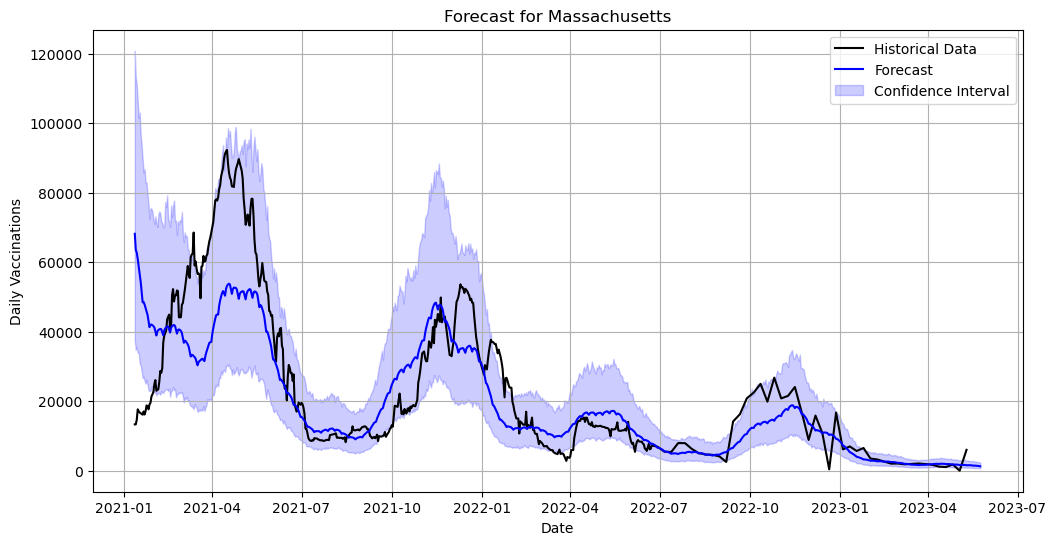

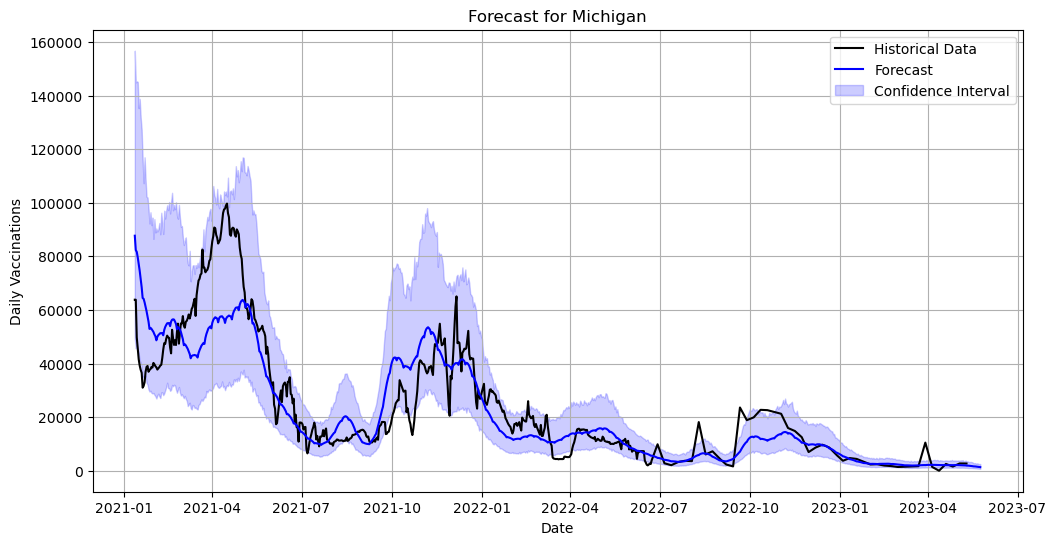

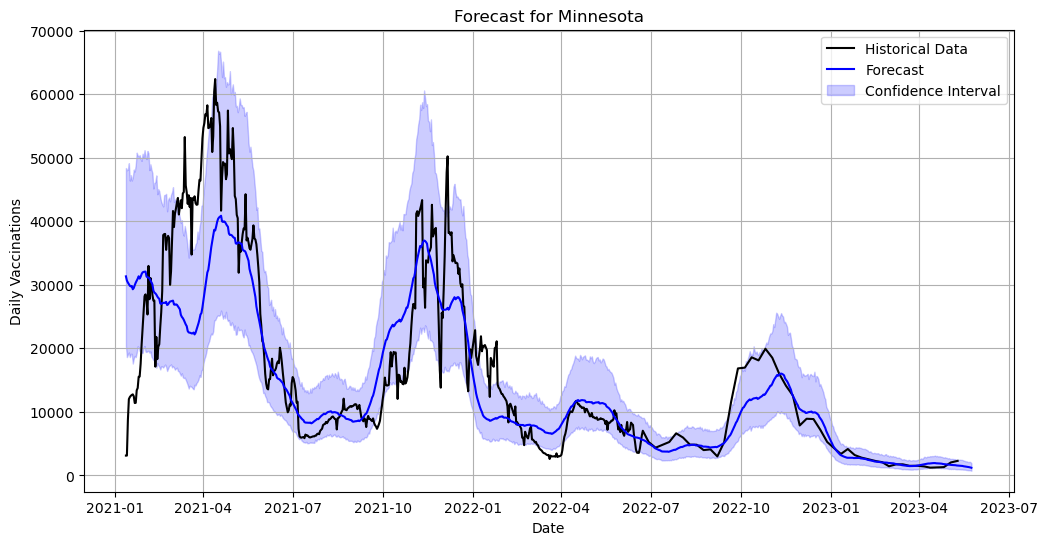

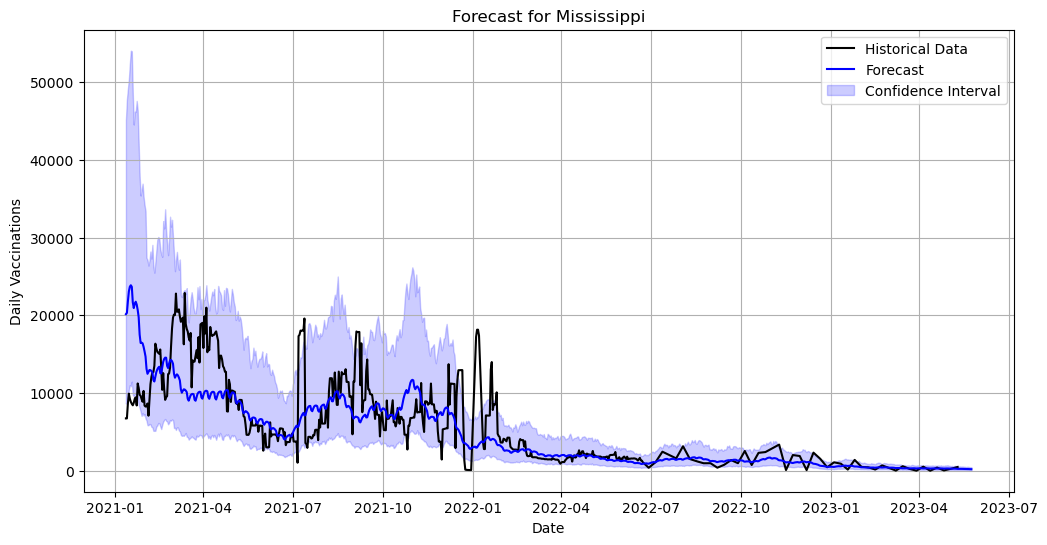

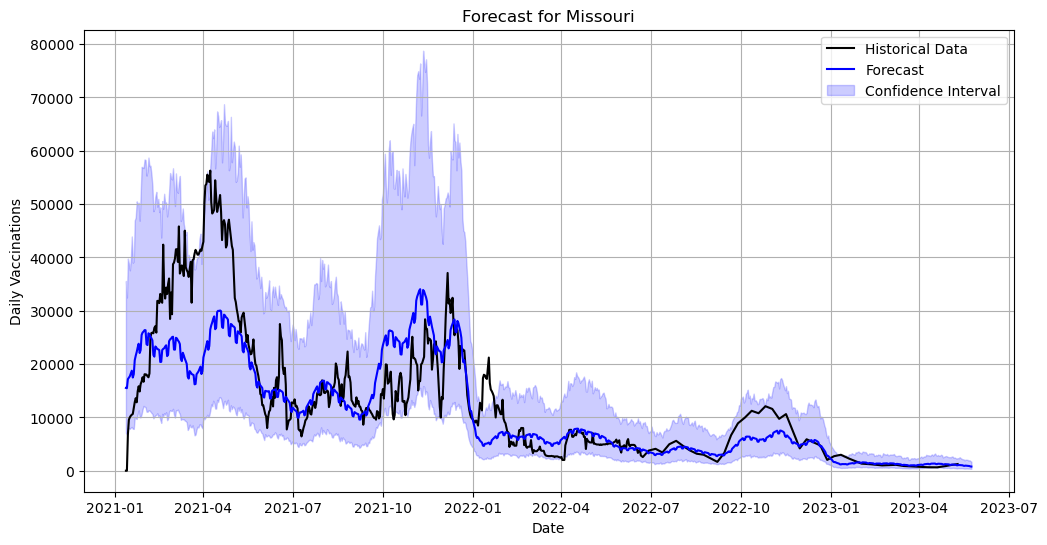

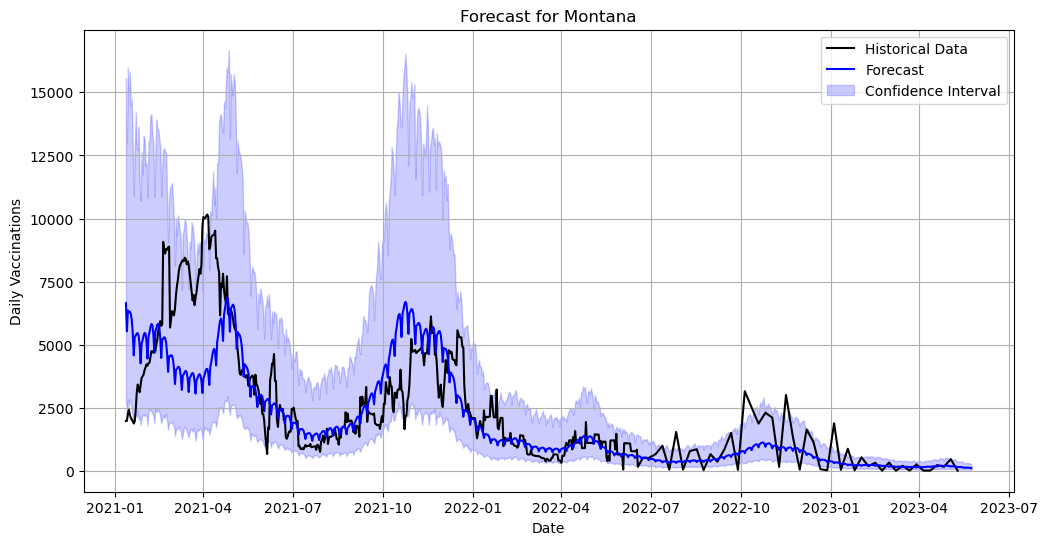

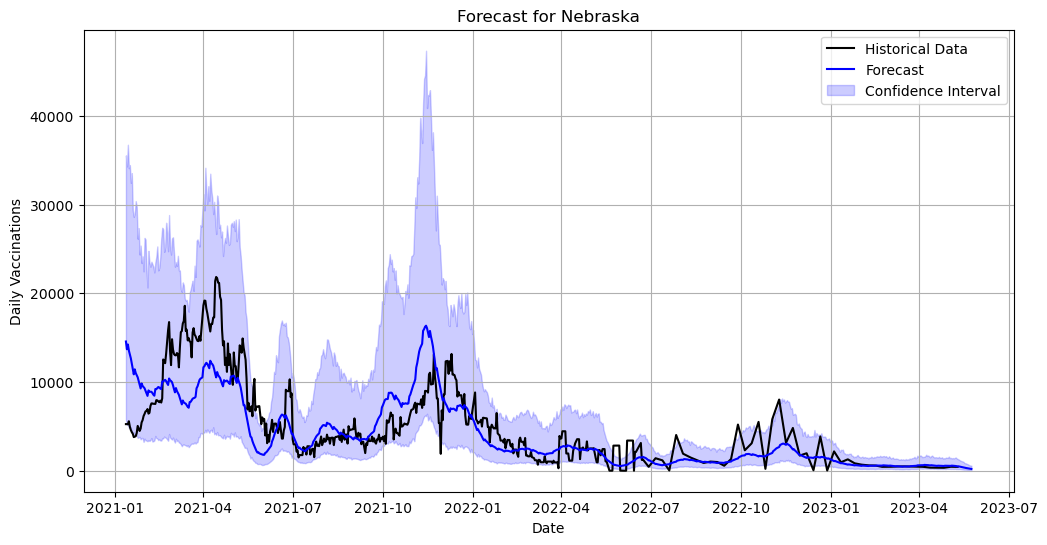

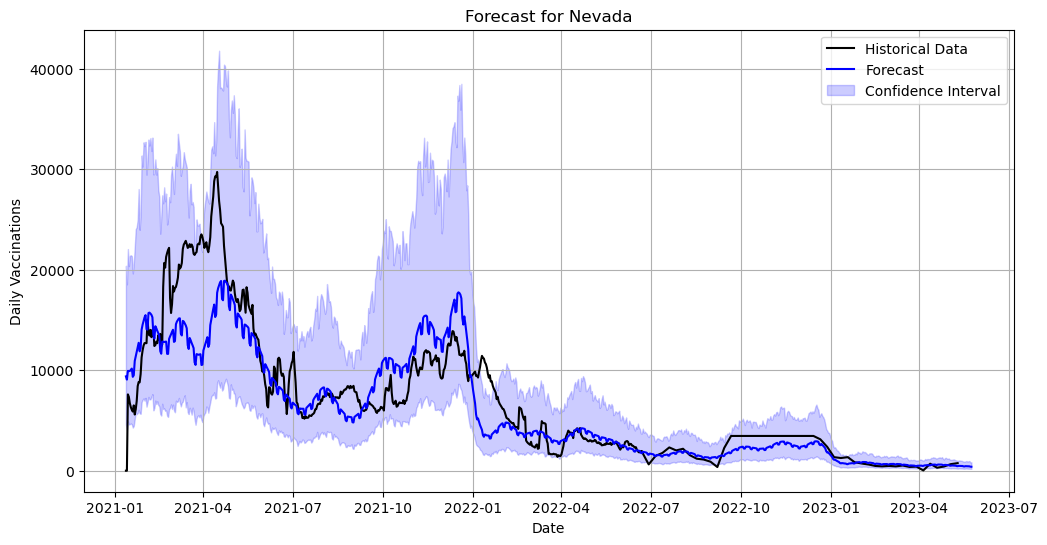

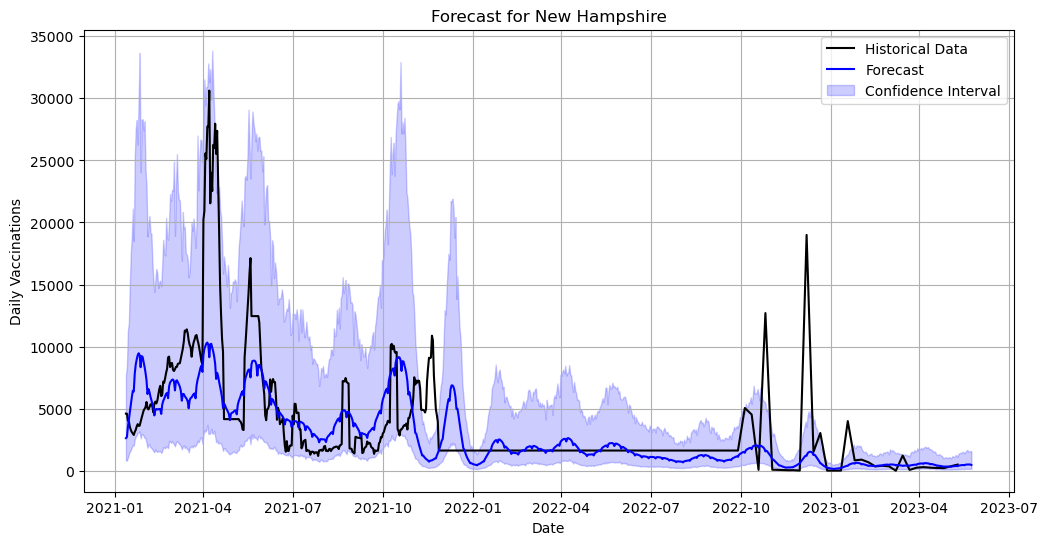

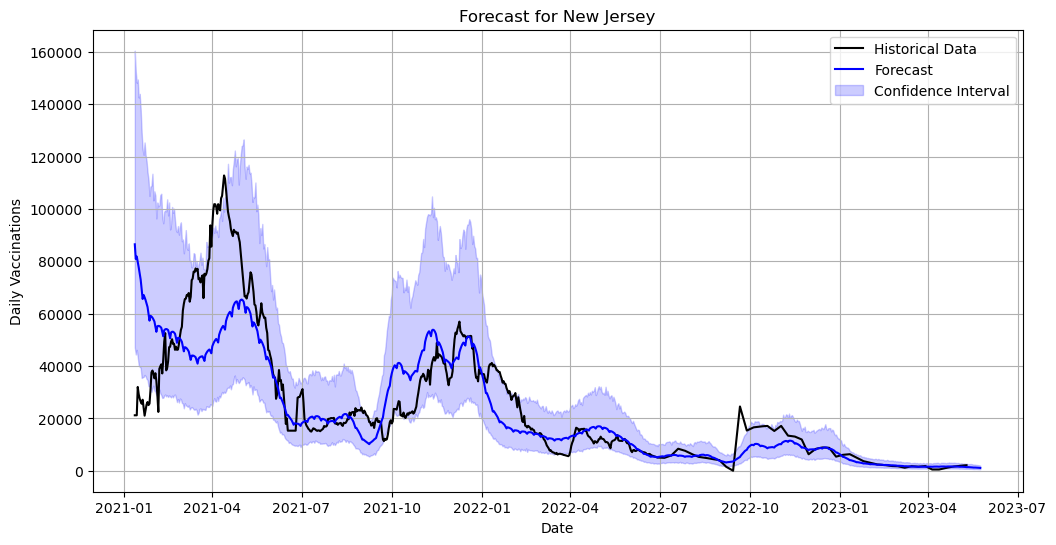

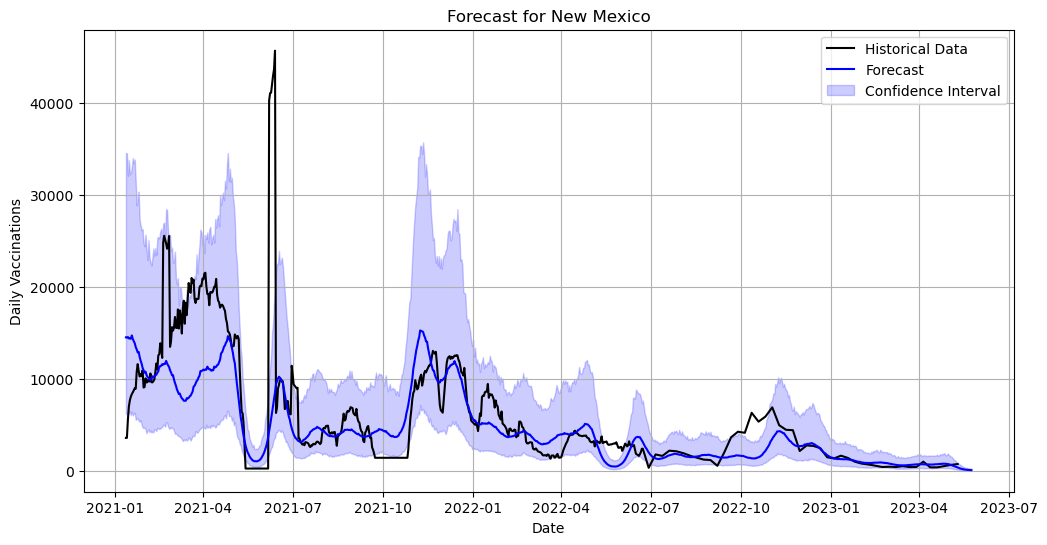

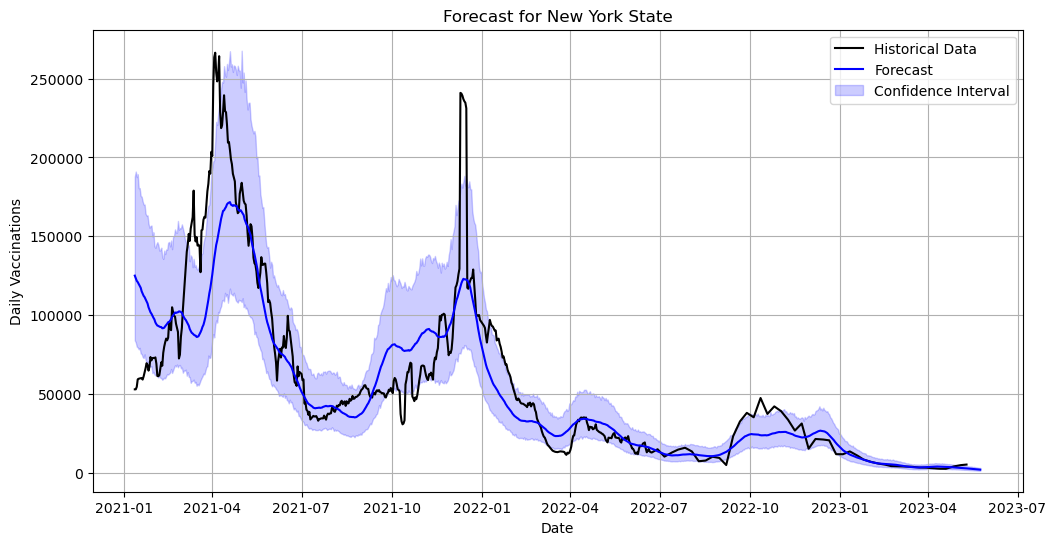

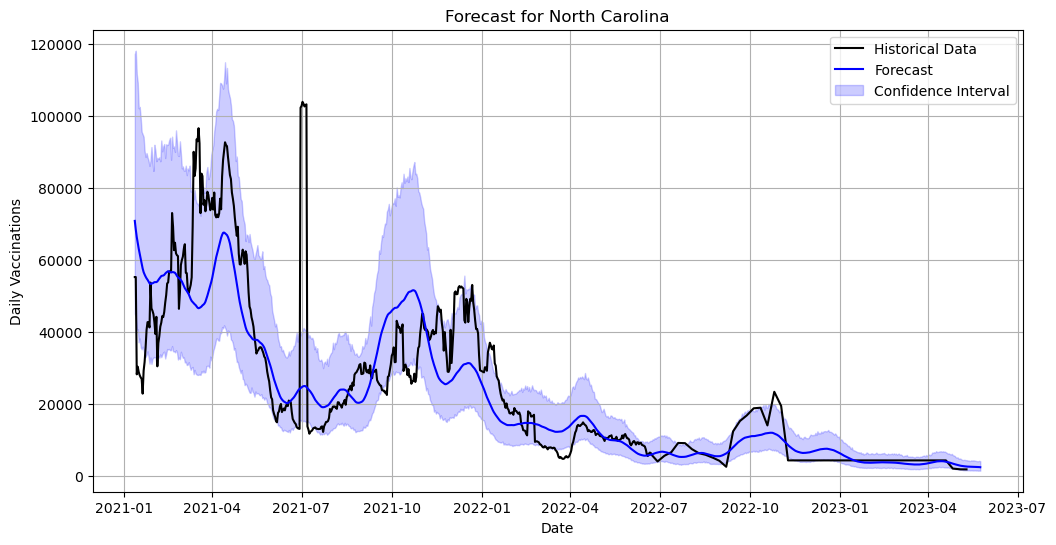

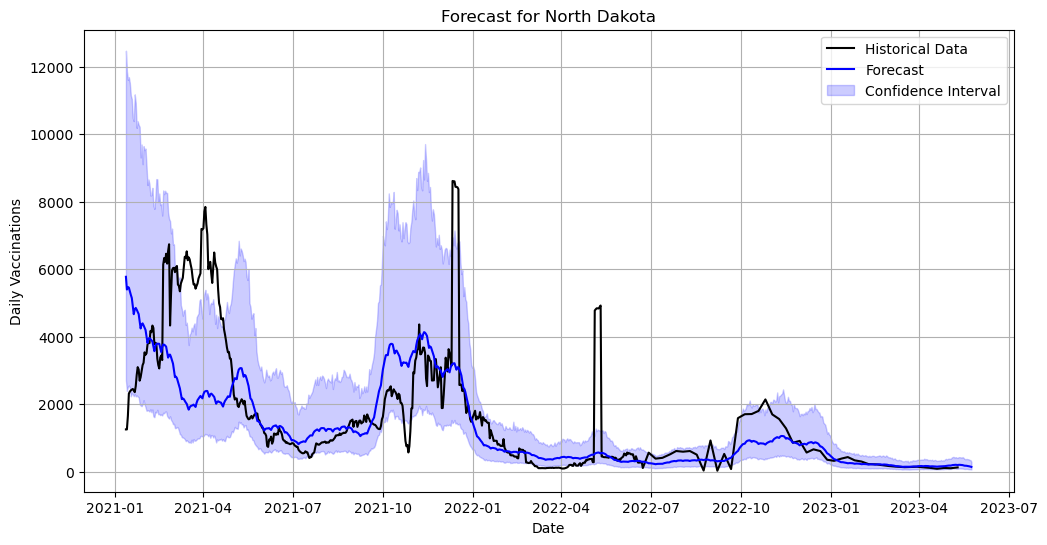

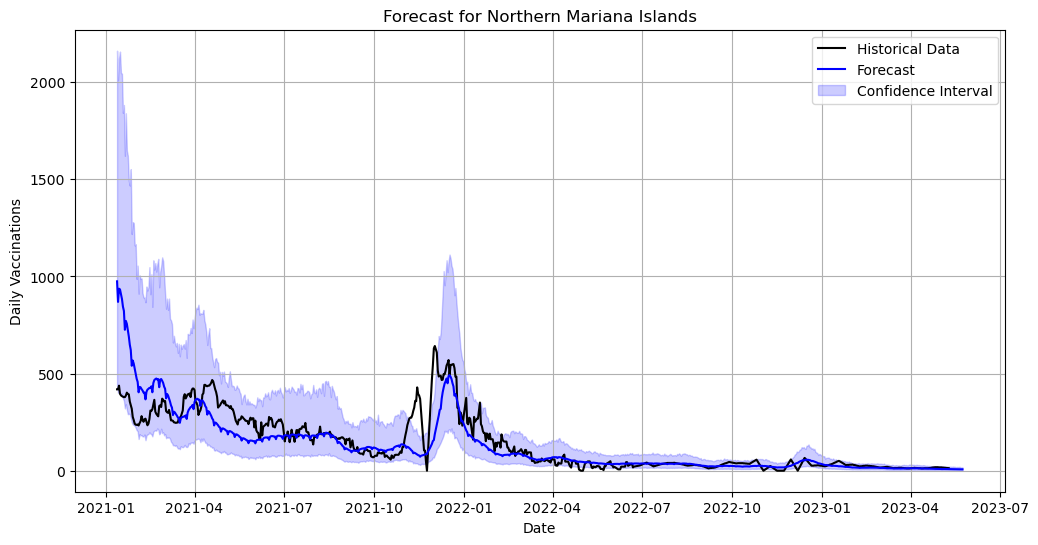

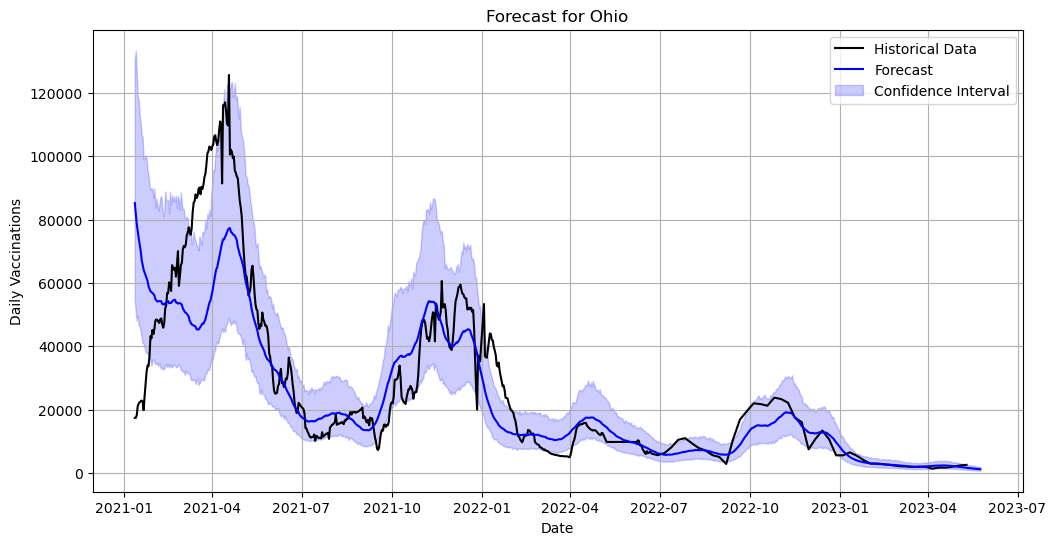

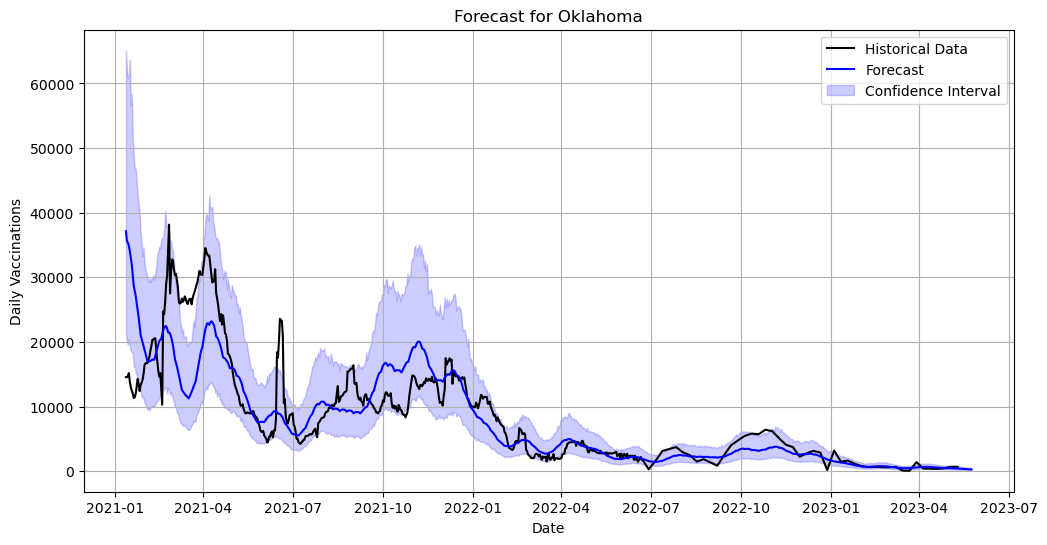

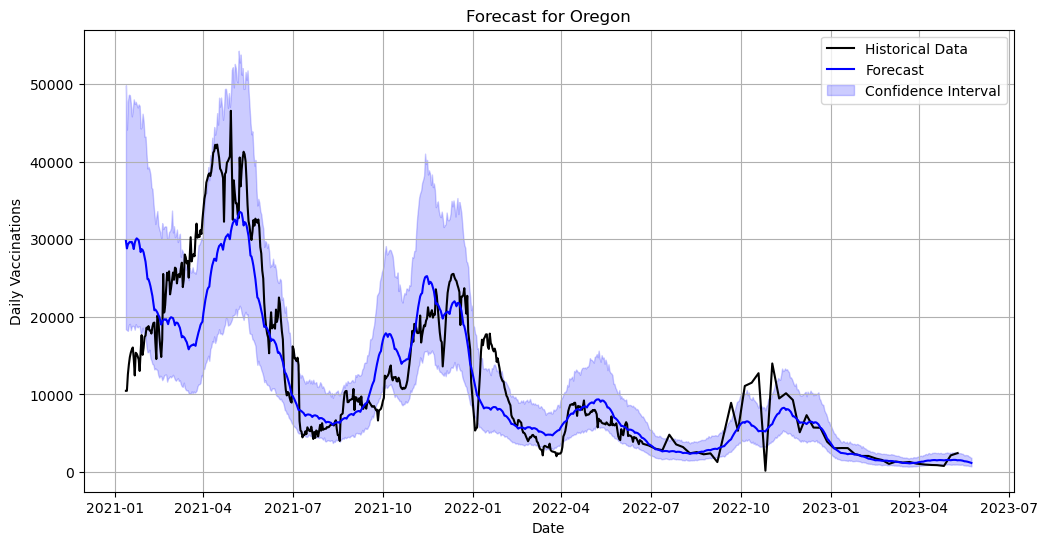

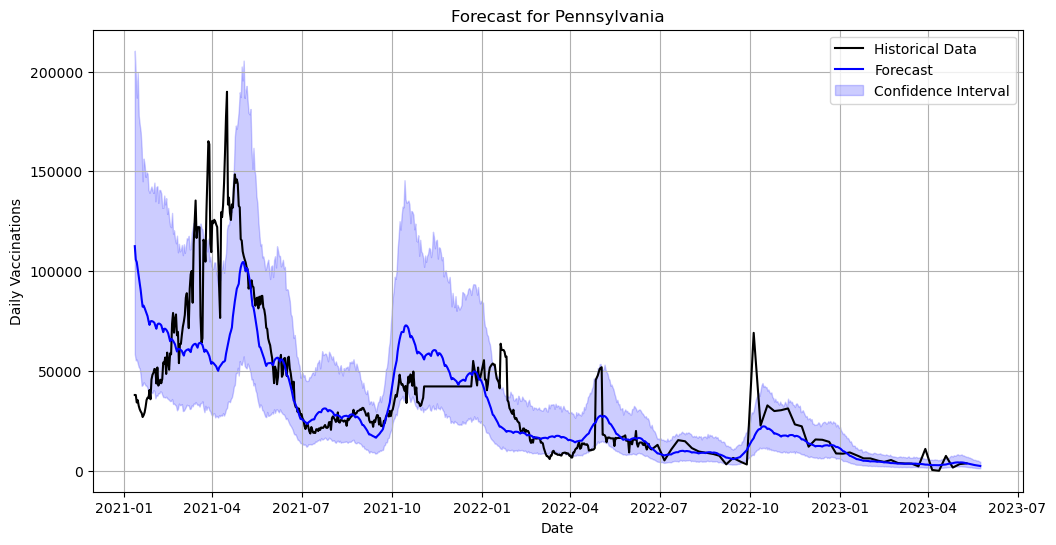

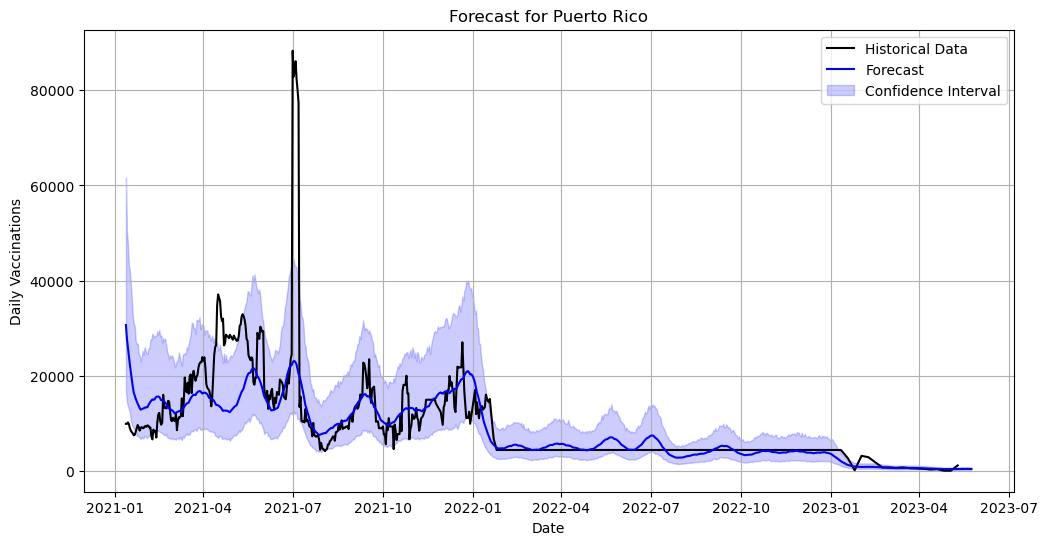

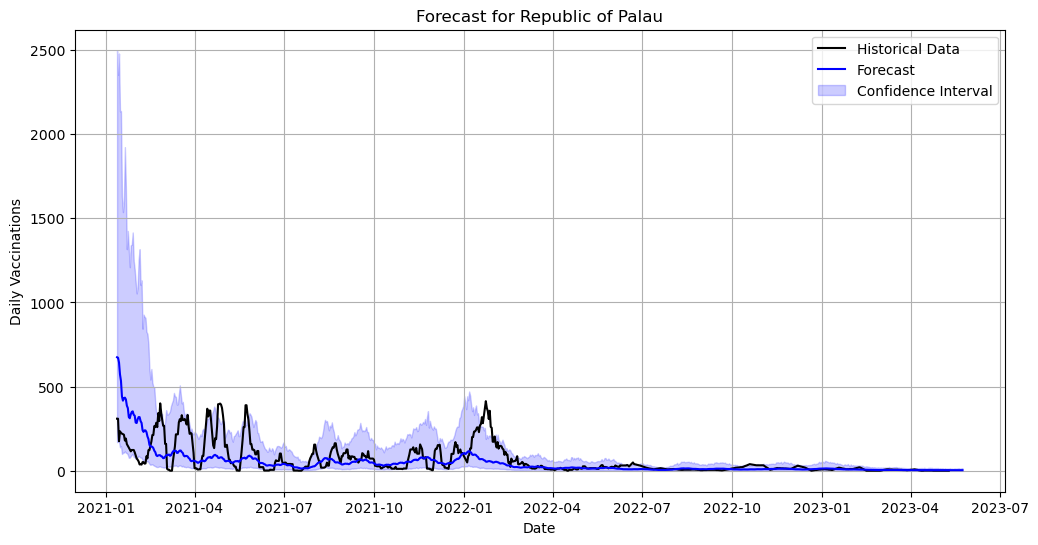

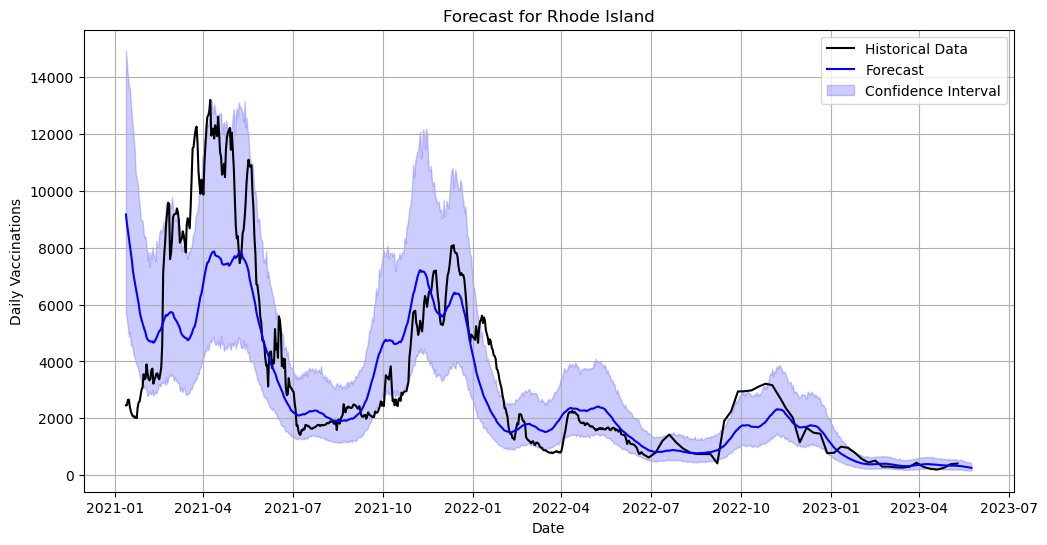

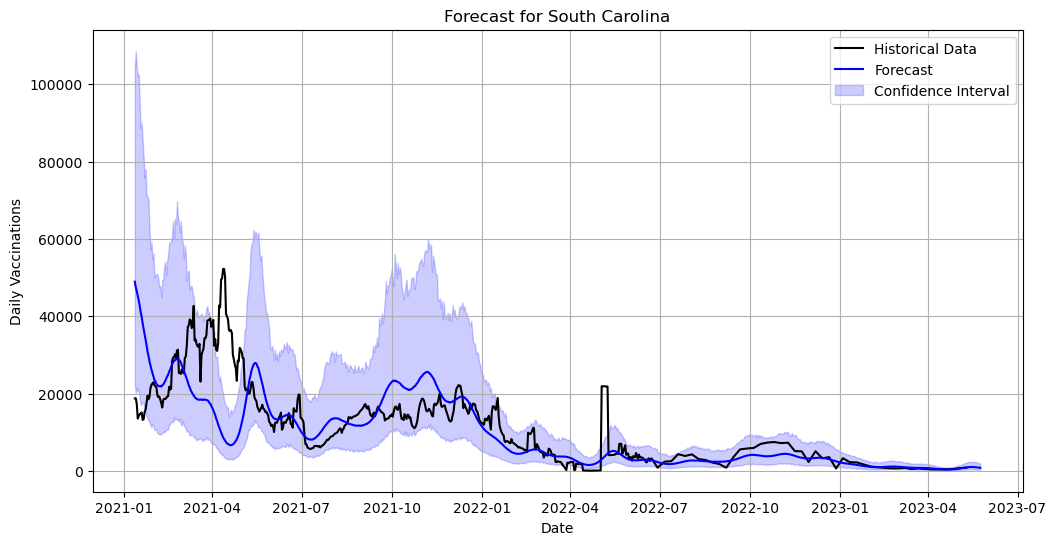

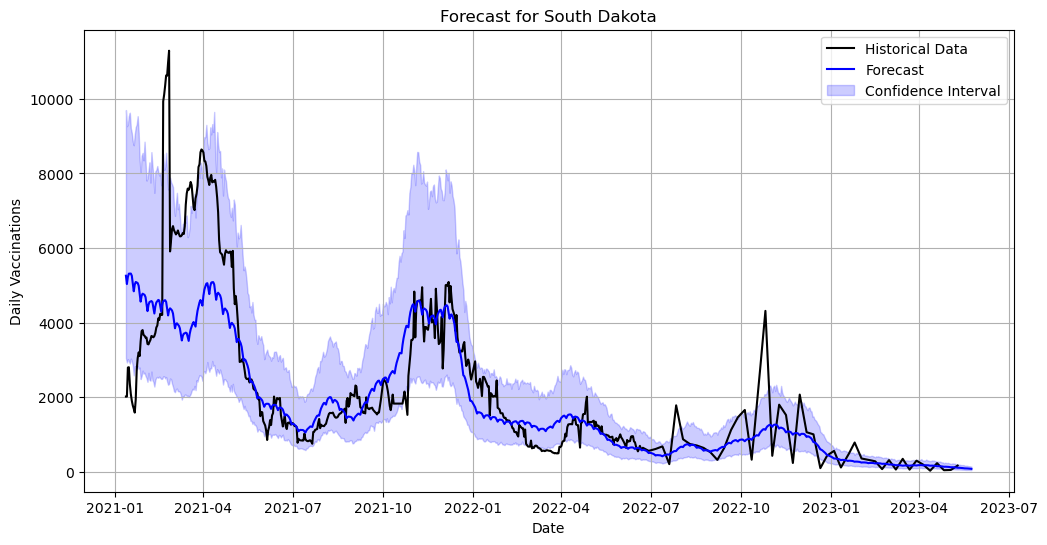

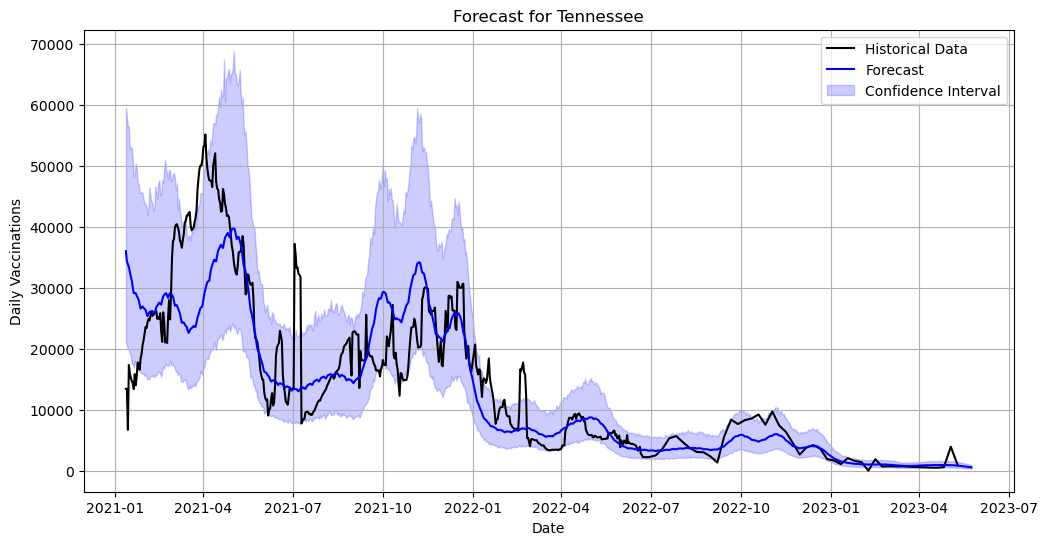

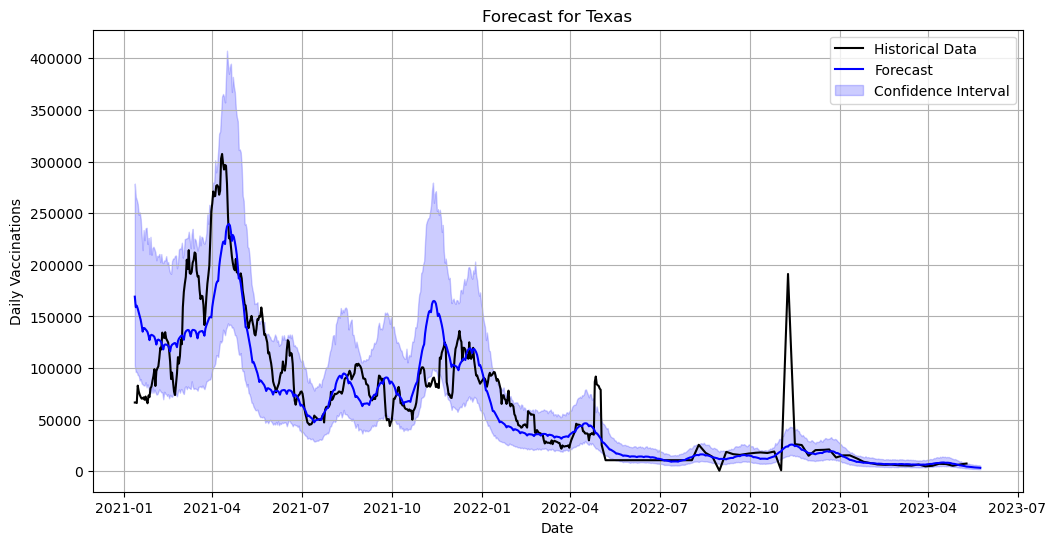

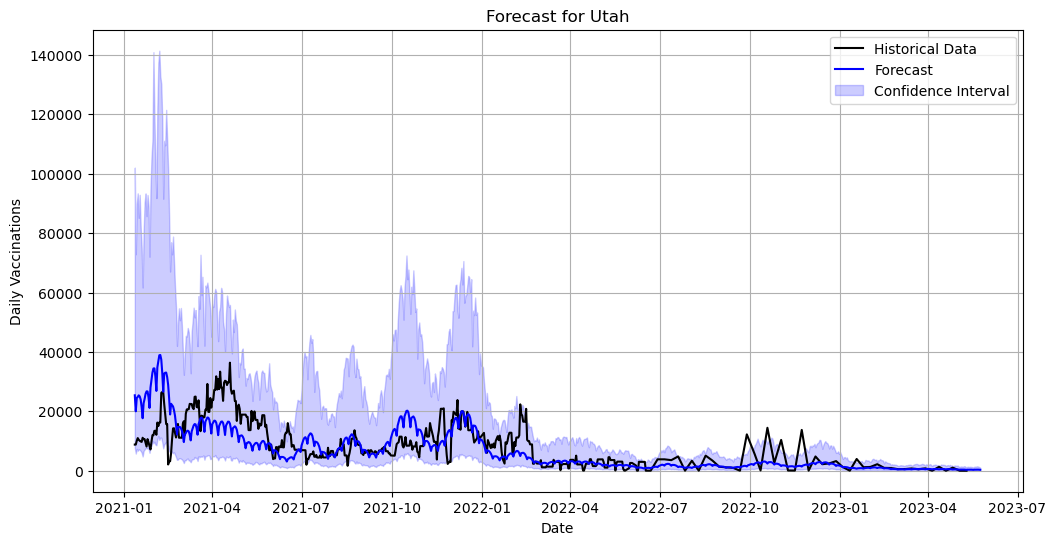

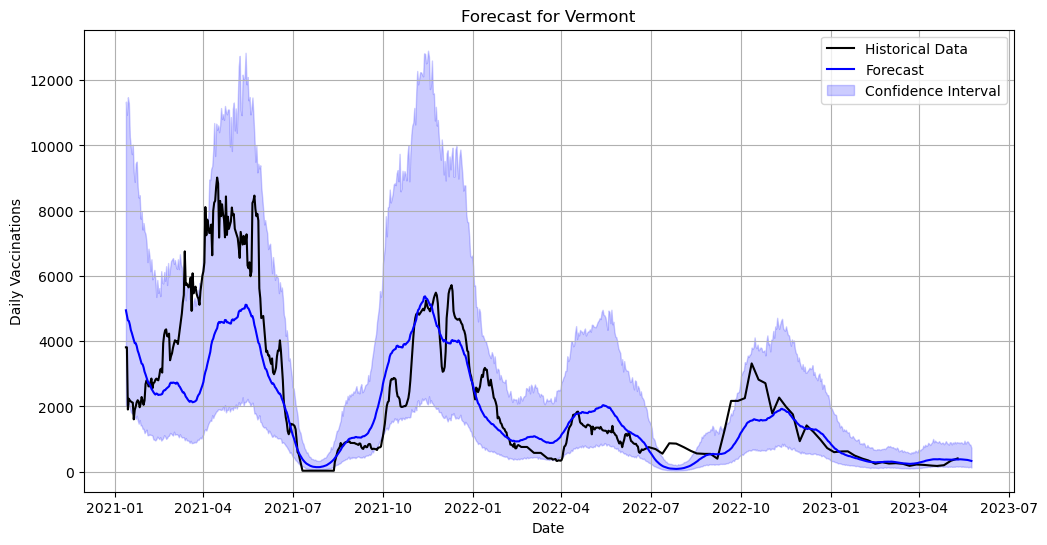

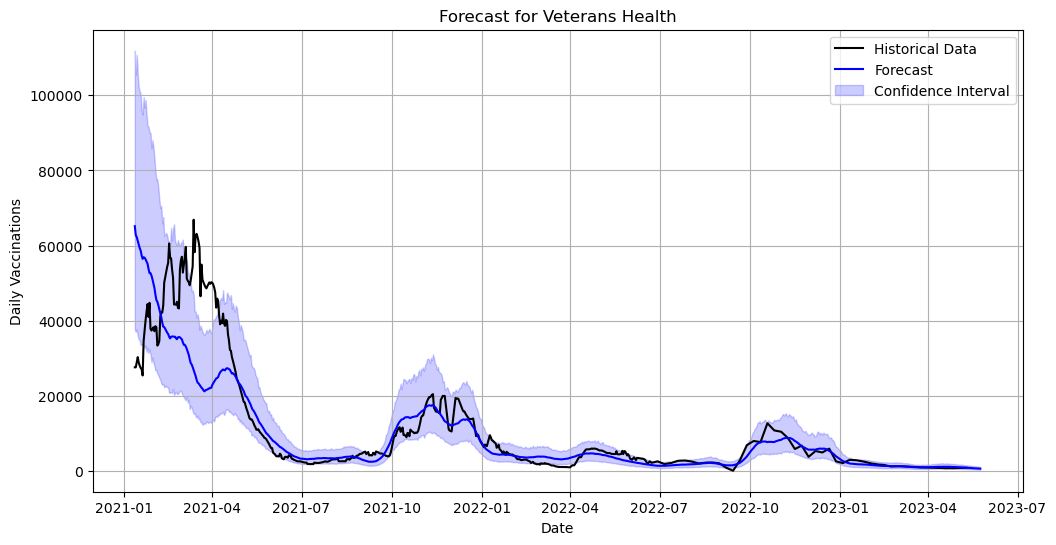

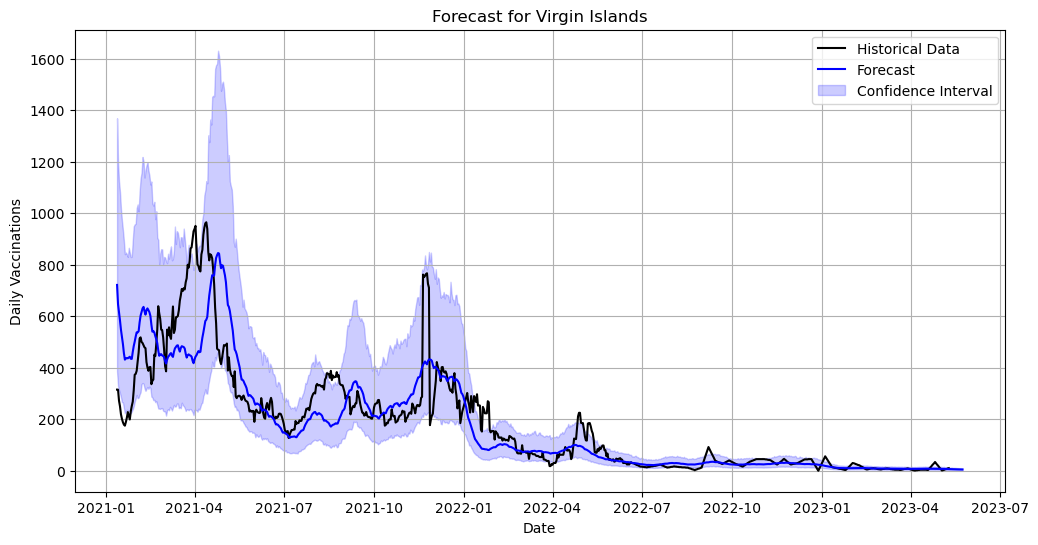

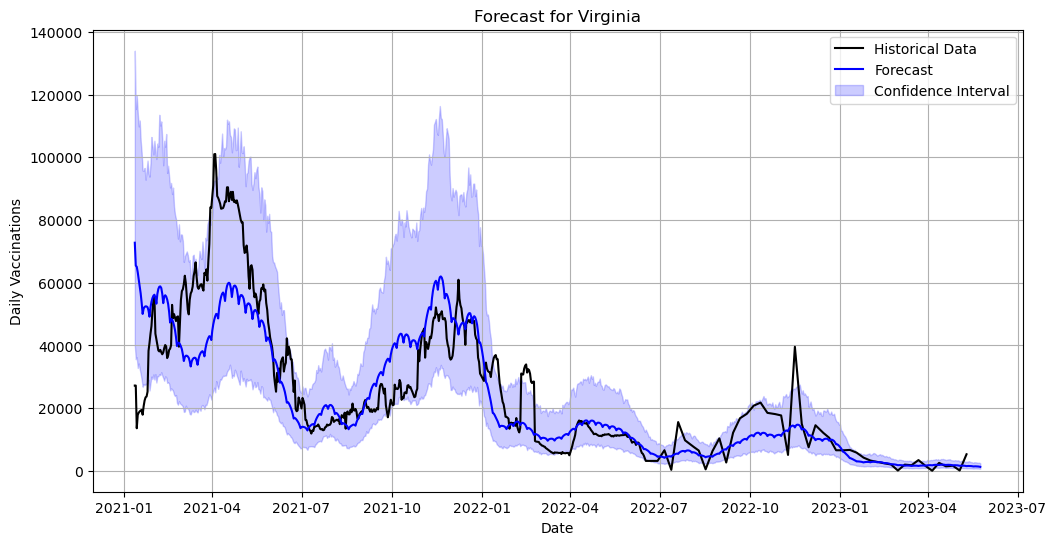

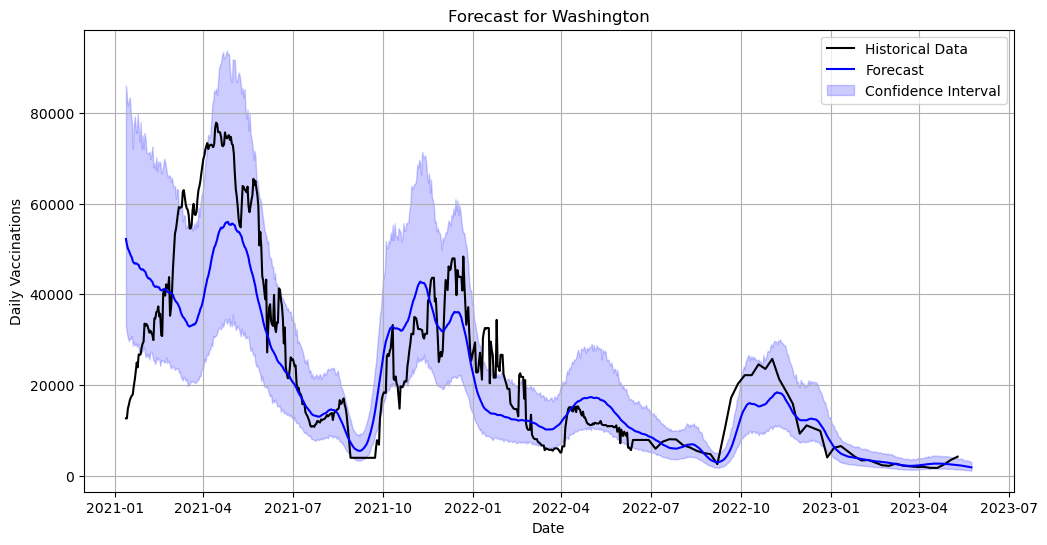

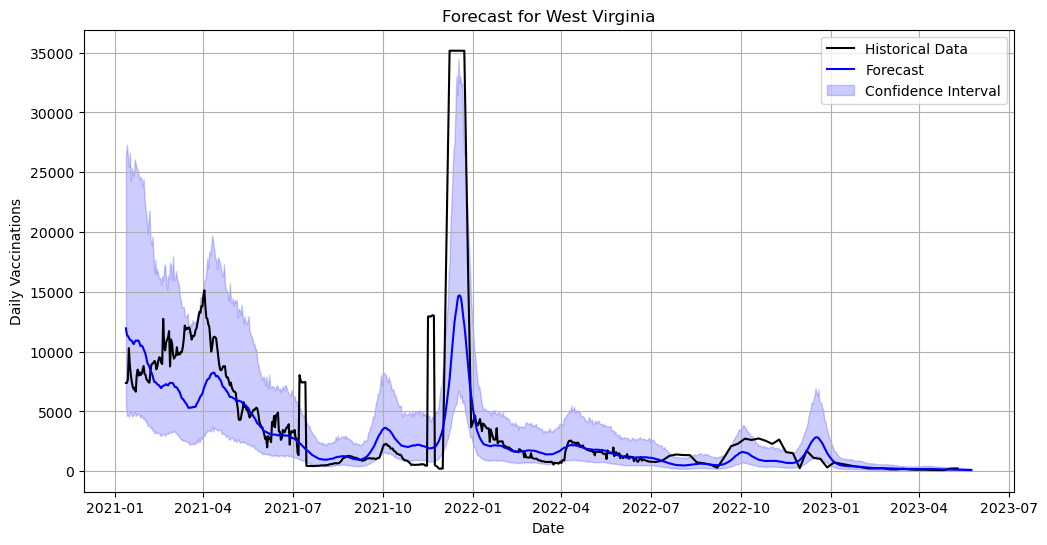

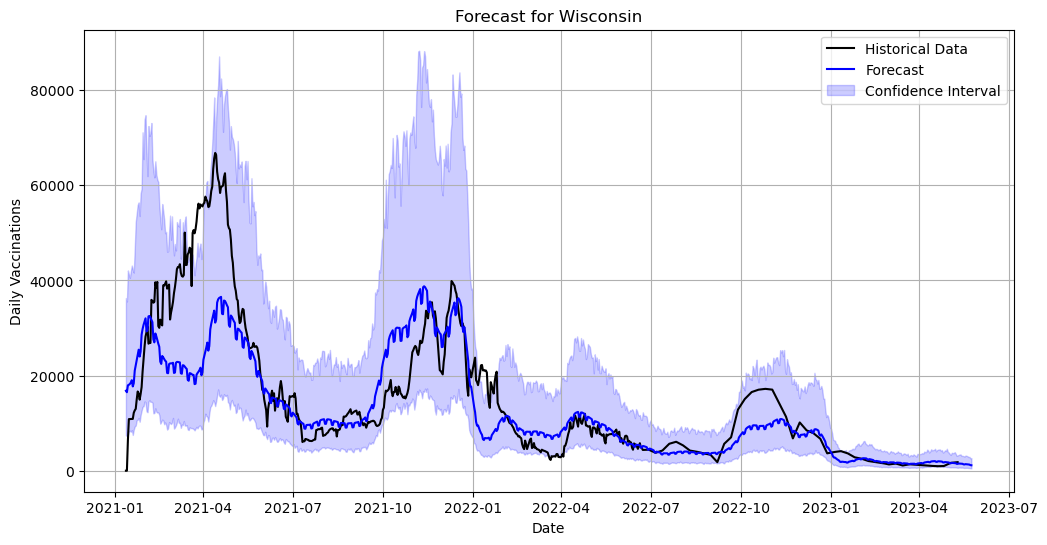

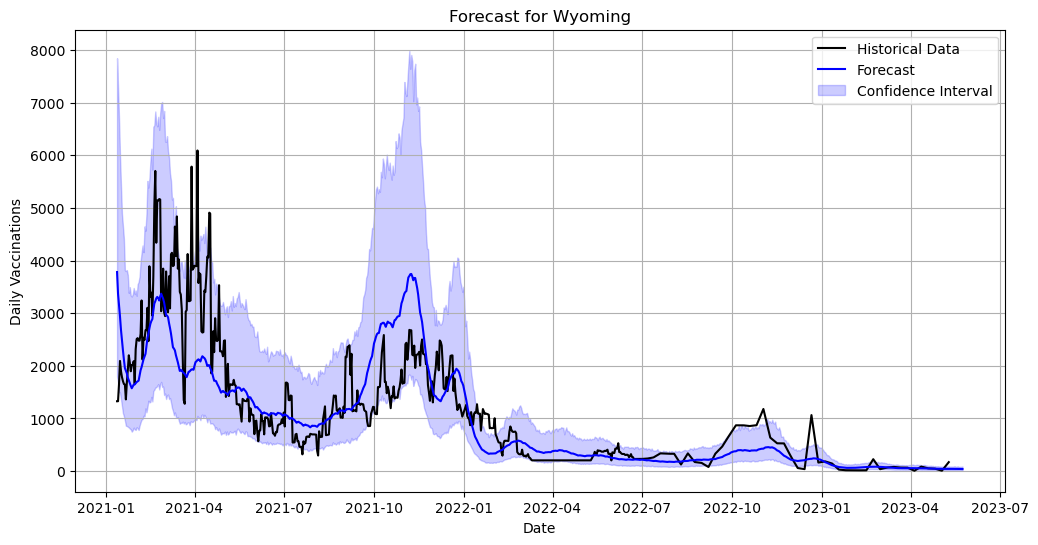

In [384]:
for location in df2['location'].unique():
    if location in forecasts:
        forecast = forecasts[location]
        location_data = df2[df2['location'] == location]
        
        plt.figure(figsize=(12, 6))
        plt.plot(location_data['date'], location_data['daily_vaccinations'], label='Historical Data', color='black')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue')
        plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')
        plt.title(f"Forecast for {location}")
        plt.xlabel("Date")
        plt.ylabel("Daily Vaccinations")
        plt.legend()
        plt.grid()
        plt.show()

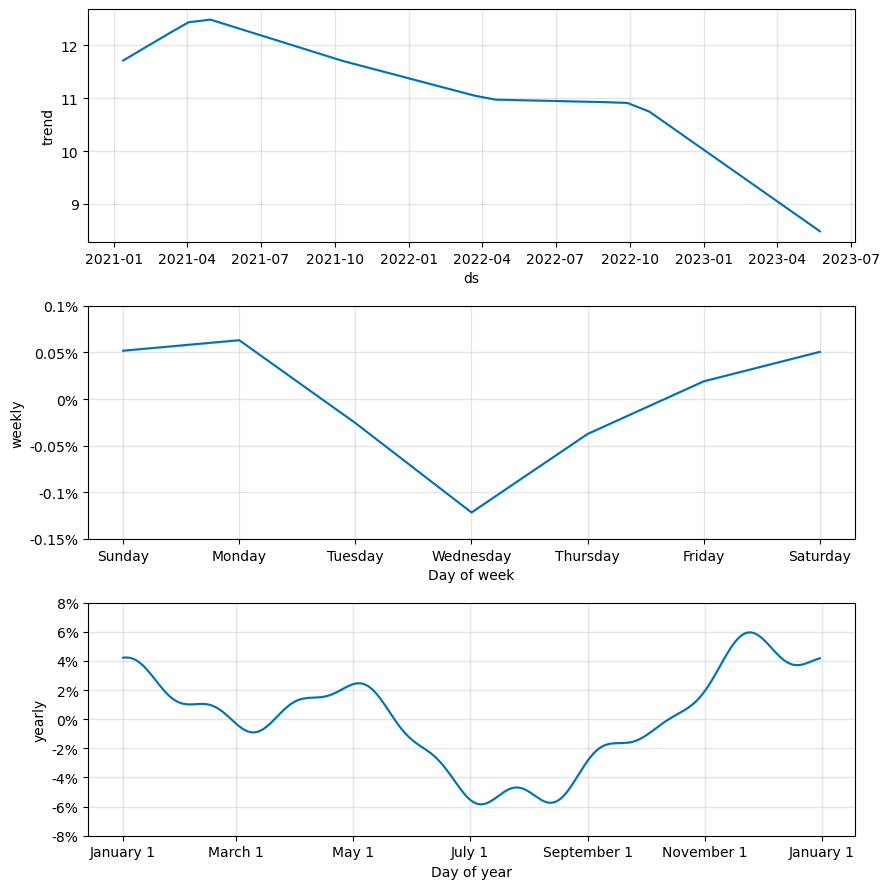

In [385]:
location = 'California'  # Example
if location in models:
    model = models[location]
    model.plot_components(forecasts[location])

C:\Users\yashv\AppData\Local\Temp\ipykernel_190196\93753478.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




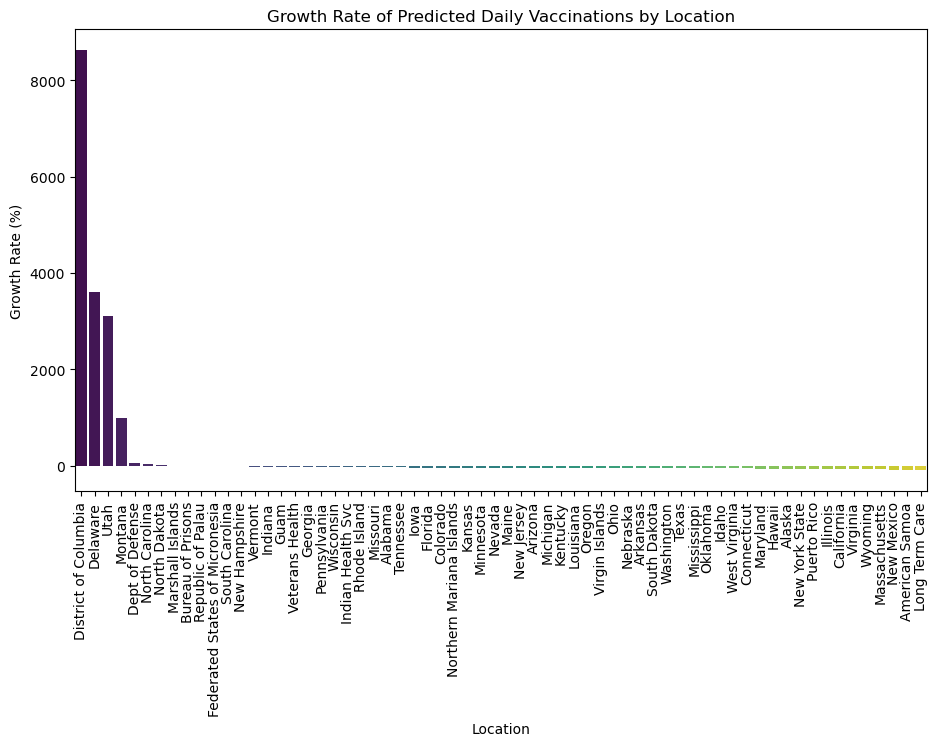

In [386]:
import seaborn as sns

plt.figure(figsize=(11, 6))
sns.barplot(data=forecast_summary.sort_values(by='growth_rate', ascending=False), x='location', y='growth_rate', palette="viridis")
plt.xticks(rotation=90)
plt.title("Growth Rate of Predicted Daily Vaccinations by Location")
plt.xlabel("Location")
plt.ylabel("Growth Rate (%)")
plt.show()

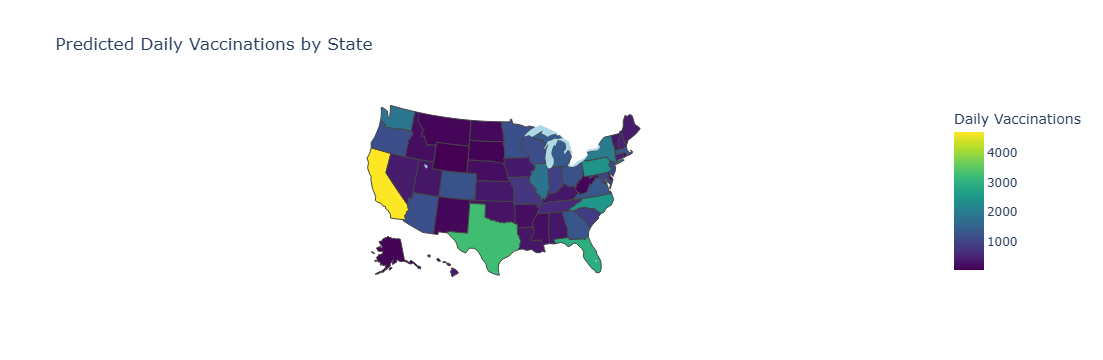

In [387]:
import plotly.express as px

map_data = forecast_summary.copy()

state_name_mapping = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York State': 'NY', 
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

map_data['state_code'] = map_data['location'].map(state_name_mapping)

state_data = map_data.dropna(subset=['state_code']).copy()

fig = px.choropleth(
    state_data,
    locations="state_code",
    locationmode="USA-states",
    color="predicted_end_value",
    scope="usa",
    title="Predicted Daily Vaccinations by State",
    color_continuous_scale="Viridis",
    range_color=[state_data['predicted_end_value'].min(), state_data['predicted_end_value'].max()],
    
    hover_name="location",
    hover_data={"predicted_end_value": True, "state_code": False}
)

fig.update_layout(
    geo=dict(
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="LightGray",
        showlakes=True,
        lakecolor="LightBlue"
    ),
    coloraxis_colorbar=dict(
        title="Daily Vaccinations"
    )
)

fig.show()